# Group comparison 3T and 7T epilepsy  

Surface-based comparisons  
- vertex-wise T-test : are controls and pts different?
- vertex-wise effect size : how big are the distances between the vertex differences?
    - Use own function


For figures: 
- Visualize effect size on a brain masked for significant p-values 

In [88]:
import pandas as pd
import numpy as np
import nibabel as nib
import pickle
import datetime
import brainstat as bstat

import importlib
import tTsTGrpUtils as tsutil
import vrtx


In [89]:
importlib.reload(tsutil)
importlib.reload(vrtx)

<module 'vrtx' from '/host/verges/tank/data/daniel/3T7T/z/code/analyses/vrtx.py'>

# MAIN

In [90]:
# specify root directories
MICs = {
    "name": "MICs",
    "dir_root": "/data/mica3/BIDS_MICs",
    "dir_deriv": "derivatives",
    "dir_mp": "micapipe_v0.2.0",
    "dir_hu": "hippunfold_v1.3.0/hippunfold",
    "study": "3T",
    "ID_ctrl" : ["HC"],
    "ID_Pt" : ["PX"]
    }

PNI = {
    "name": "PNI",
    "dir_root": "/data/mica3/BIDS_PNI",
    "dir_deriv": "derivatives",
    "dir_mp": "micapipe_v0.2.0",
    "dir_hu": "hippunfold_v1.3.0/hippunfold",
    "study": "7T",
    "ID_col" : ["PNC", "Pilot"], # column for ID in demographics file
    }

studies = [MICs, PNI]

demographics = {
    "pth" : "/host/verges/tank/data/daniel/3T7T/z/data/pt/demo_23May2025.csv",
    # column names:
    "ID_7T" : "PNI_ID", 
    "ID_3T" : "MICS_ID",
    "SES" : "SES",
    "date": "Date",
    "grp" : "grp_detailed" # col name for participant grouping variable of interest
}

px_grps = { # specify patient group labels to compare to controls
    'allPX' : ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R'],
    'TLE' : ['TLE_L', 'TLE_R', 'TLE_U', 'mTLE_R', 'mTLE_L'],
    'TLE_L': ['TLE_L', 'mTLE_L', 'bTLE_L'],
    'TLE_R': ['TLE_R', 'mTLE_R', 'bTLE_R'],
    'FCD' : ['FLE_R', 'FLE_L'],
    'MFCL' : ['MFCL', 'bTLE'],
    'UKN' : ['UKN_L', 'UKN_U']
}

ctrl_grp = {'ctrl' : ['CTRL']}

# Make list of dict items for group definitions
groups = [
    {'TLE_L': px_grps['TLE_L']},
    {'TLE_R': px_grps['TLE_R']},
    ctrl_grp
]

#features = ["thickness"]

lbls = ["thickness"]
lbls_hipp = ["midthickness"]

surfs = ["fsLR-32k"]
surfs_hipp = ["0p5mm"]

demo = pd.read_csv(demographics['pth'], dtype=str)

In [91]:
groups

[{'TLE_L': ['TLE_L', 'mTLE_L', 'bTLE_L']},
 {'TLE_R': ['TLE_R', 'mTLE_R', 'bTLE_R']},
 {'ctrl': ['CTRL']}]

# Smooth maps  
each row = participant

In [92]:

# Add paths to surfaces (with features of interest), and cortical surfaces (at depths of interest) to demo_pths.
demo_pths = demo[["MICS_ID", "PNI_ID", "study", "SES", "Date", "grp", "grp_detailed"]]

smth_map_save_dir = "/host/verges/tank/data/daniel/3T7T/z/maps"
surf = "fsLR-32k"
smth_kernel = 10 # smoothing kernel in mm
importlib.reload(tsutil)

for idx, row in demo_pths.iterrows(): # Iterate through rows and fill in paths
    study_code = row['study']
    
    if study_code == "3T":
        study = MICs
        ID_col = demographics['ID_3T']
    elif study_code == "7T":
        study = PNI
        ID_col = demographics['ID_7T']
    else:
        print(f"Warning: Unknown study code `{study_code}` (index {idx}). Skipping row.")
        continue
    
    sub = row[ID_col]
    ses = row['SES']
    print(f"\n\n{study_code} sub-{sub} ses-{ses}")
    
    # Define micapipe path
    mp_root = f"{study['dir_root']}/{study['dir_deriv']}/{study['dir_mp']}"

    # Find surface paths for each label (L/R)
    for lbl in lbls:
        #print(f"\tLabel: {lbl}")
        suffix_L = 'L'
        suffix_R = 'R'

        surf_L, surf_R = tsutil.get_surf_pth(
            root=mp_root,
            sub=sub,
            ses=ses,
            res = "fsLR-32k",
            lbl= "midthickness"
        )
        
        surf_L = surf_L if tsutil.chk_pth(surf_L) else None
        surf_R = surf_R if tsutil.chk_pth(surf_R) else None        
        #print(f"\tSurfaces:\t{surf_L}\n\t\t\t{surf_R}")

        if surf_L is not None or surf_R is not None:
            # get path to unsmoothed map
            pth_map_unsmth_L = f"{mp_root}/sub-{sub}/ses-{ses}/maps/sub-{sub}_ses-{ses}_hemi-L_surf-fsLR-32k_label-{lbl}.func.gii"
            pth_map_unsmth_R = f"{mp_root}/sub-{sub}/ses-{ses}/maps/sub-{sub}_ses-{ses}_hemi-R_surf-fsLR-32k_label-{lbl}.func.gii"

            #print(f"{pth_map_unsmth_L}\n{pth_map_unsmth_R}")
            map_unsmth_L = pth_map_unsmth_L if tsutil.chk_pth(pth_map_unsmth_L) else None
            map_unsmth_R = pth_map_unsmth_L if tsutil.chk_pth(pth_map_unsmth_L) else None
            #print(f"\tRaw maps:\t{map_unsmth_L}\n\t\t\t{map_unsmth_R}")

            if map_unsmth_L is not None or map_unsmth_R is not None:
                # create smoothed feature maps
                out_dir = f"{smth_map_save_dir}/sub-{sub}_ses-{ses}"
                tsutil.create_dir(out_dir)


                out_pth_L = f"{out_dir}/sub-{sub}_ses-{ses}_hemi-L_surf-fsLR-32k_label-{lbl}"
                out_pth_R = f"{out_dir}/sub-{sub}_ses-{ses}_hemi-R_surf-fsLR-32k_label-{lbl}"
                


                map_smth_L = tsutil.smooth_map(surf_L, map_unsmth_L, out_pth_L, kernel=10)
                map_smth_R = tsutil.smooth_map(surf_R, map_unsmth_R, out_pth_R, kernel=10)
                #print(f"{map_smth_L}\n{map_smth_R}")

                if map_smth_L is not None and map_smth_R is not None:
                    # Add paths to DataFrame
                    #print(f"Adding to df: {map_smth_L}\t{map_smth_R}")
                    demo_pths.loc[idx, f"{lbl}_map_smth_{smth_kernel}_L"] = map_smth_L
                    demo_pths.loc[idx, f"{lbl}_map_smth_{smth_kernel}_R"] = map_smth_R

demo_pths



7T sub-PNC019 ses-01
	[smooth_map] Smoothed map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC019_ses-01/sub-PNC019_ses-01_hemi-L_surf-fsLR-32k_label-thickness_smth-10.func.gii
	[smooth_map] Smoothed map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC019_ses-01/sub-PNC019_ses-01_hemi-R_surf-fsLR-32k_label-thickness_smth-10.func.gii


7T sub-PNC019 ses-02


/tmp/ipykernel_4048221/2319290178.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_pths.loc[idx, f"{lbl}_map_smth_{smth_kernel}_L"] = map_smth_L
/tmp/ipykernel_4048221/2319290178.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_pths.loc[idx, f"{lbl}_map_smth_{smth_kernel}_R"] = map_smth_R


	[smooth_map] Smoothed map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC019_ses-02/sub-PNC019_ses-02_hemi-L_surf-fsLR-32k_label-thickness_smth-10.func.gii
	[smooth_map] Smoothed map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC019_ses-02/sub-PNC019_ses-02_hemi-R_surf-fsLR-32k_label-thickness_smth-10.func.gii


7T sub-PNC019 ses-03
	[smooth_map] Smoothed map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC019_ses-03/sub-PNC019_ses-03_hemi-L_surf-fsLR-32k_label-thickness_smth-10.func.gii
	[smooth_map] Smoothed map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC019_ses-03/sub-PNC019_ses-03_hemi-R_surf-fsLR-32k_label-thickness_smth-10.func.gii


7T sub-PNC019 ses-04
	[smooth_map] Smoothed map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC019_ses-04/sub-PNC019_ses-04_hemi-L_surf-fsLR-32k_label-thickness_smth-10.func.gii
	[smooth_map] Smoothed map saved to: /host/verges/tank/data/daniel/3T7T/z/maps/sub-PNC019_ses-04/sub-PNC019_s

,MICS_ID,PNI_ID,study,SES,Date,grp,grp_detailed,thickness_map_smth_10_L,thickness_map_smth_10_R
0,HC062,PNC019,7T,01,20.04.2023,CTRL,CTRL,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...
1,HC062,PNC019,7T,02,03.05.2023,CTRL,CTRL,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...
2,HC062,PNC019,7T,03,17.05.2023,CTRL,CTRL,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...
3,HC062,PNC019,7T,04,07.11.2023,CTRL,CTRL,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...
4,HC062,PNC019,7T,a1,11.12.2024,CTRL,CTRL,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...
...,...,...,...,...,...,...,...,...,...
116,PX204,PNE019,3T,01,09.01.2025,TLE,TLE_L,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...
117,PX215,PNE020,7T,a1,27.03.2025,UKN,UKN_U,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...
118,PX215,PNE020,3T,01,20.03.2025,UKN,UKN_U,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...
119,PX216,PNE021,7T,a1,02.04.2025,TLE,TLE_R,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...,/host/verges/tank/data/daniel/3T7T/z/maps/sub-...


In [93]:
# Save the updated DataFrame to a CSV file
dir_save = "/host/verges/tank/data/daniel/3T7T/z/maps/paths"
date = pd.Timestamp.now().strftime("%d%b%Y-%H%M")
demo_pths.to_csv(f"{dir_save}/demo_paths_{date}.csv", index=False)
print(f"Saved smoothed map paths to {dir_save}/demo_paths_{date}.csv")

Saved smoothed map paths to /host/verges/tank/data/daniel/3T7T/z/maps/paths/demo_paths_11Jun2025-1538.csv


# Extract maps (dict item for each feature, grp)

In [94]:
# Create dict item for each, group, study, feature, label pair (including hippocampal features/labels)

map_dictlist = []
lbl = "thickness"
smth = 10

for study in studies:
    study_name = study['name']
    study_code = study['study']
    ID_col = demographics['ID_3T'] if study_name == "MICs" else demographics['ID_7T']

    # Iterate through all groups (patients and controls)
    for grp_idx in groups:
        for grp_code, grp_labels in grp_idx.items():
            print(f"[{study_code}] {grp_code}: {grp_labels}")
            df_demo = demo_pths[
                            (demo['study'] == study_code) &
                            (demo['grp_detailed'].isin(grp_labels))
                ].copy()
            #print(f"\tsubs: {len(df_demo)}")

            col_L = f"{lbl}_map_smth_{smth}_L"
            col_R = f"{lbl}_map_smth_{smth}_R"
            
            # remove any rows where either left or right map is missing
            df_demo_clean = df_demo.dropna(subset=[col_L, col_R])
            #print(f"\t{len(df_demo_clean)}")

            # choose most recent session for each participant
            df_demo_clean = df_demo_clean.sort_values(by=['Date'], ascending=False).drop_duplicates(subset=[ID_col], keep='first')
            df_demo_clean.rename(columns={ID_col: 'ID'}, inplace=True)
            print(f"\tn (clean): {df_demo_clean.shape}")

            # read in the maps and append to df_maps
            df_maps = df_demo_clean[['ID', 'SES', col_L, col_R]].copy()
            # rename Id col to ID
      
            #print(f"{df_maps.shape}")
            
            # Stack all left hemisphere maps into a DataFrame (vertices as columns)
            # Stack all left hemisphere maps into a DataFrame (vertices as columns)
            map_L_matrix = np.vstack([nib.load(x).darrays[0].data for x in df_maps[col_L]])
            map_R_matrix = np.vstack([nib.load(x).darrays[0].data for x in df_maps[col_R]])

            # Convert to DataFrame for easier handling
            map_L_df = pd.DataFrame(map_L_matrix, index=df_maps.index)
            map_R_df = pd.DataFrame(map_R_matrix, index=df_maps.index)

            # Rename columns to indicate hemisphere and vertex index
            map_L_df.columns = [f"{v}_L" for v in map_L_df.columns]
            map_R_df.columns = [f"{v}_R" for v in map_R_df.columns]

            #print(f"\tmap shapes: {map_L_df.shape}, {map_R_df.shape} (tot cols: {map_L_df.shape[1] + map_R_df.shape[1]})")
            
            # append map_L_df and map_R_df to df_maps. Remove the original columns col_L and col_R from df_maps
            df_maps = df_maps.drop(columns=[col_L, col_R])
            #print(f"\tdf_maps cols: {df_maps.columns}")
            
            df_maps = pd.concat([df_maps, map_L_df, map_R_df], axis=1)
            print(f"\tShape:{df_maps.shape}")

            map_dictlist.append({
                                'study': study_name,
                                'grp': grp_code,
                                'grp_labels': grp_labels,
                                'label': lbl,
                                'hippocampal': False,
                                'df_demo': df_demo_clean,
                                'df_maps': df_maps
                            })

print(f"{len(map_dictlist)}")    

# Save map_pths as a pickle file
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
save_pth = "/host/verges/tank/data/daniel/3T7T/z/maps/map_dfs"
save_name = f"{save_pth}/map_values_{date}.pkl"

with open(save_name, "wb") as f:
    pickle.dump(map_dictlist, f)
print(f"Saved list of dictionary items (map_pths) to {save_pth}/map_pths_{date}.pkl")

[3T] TLE_L: ['TLE_L', 'mTLE_L', 'bTLE_L']
	n (clean): (5, 9)
	Shape:(5, 64986)
[3T] TLE_R: ['TLE_R', 'mTLE_R', 'bTLE_R']
	n (clean): (4, 9)
	Shape:(4, 64986)
[3T] ctrl: ['CTRL']
	n (clean): (11, 9)
	Shape:(11, 64986)
[7T] TLE_L: ['TLE_L', 'mTLE_L', 'bTLE_L']
	n (clean): (5, 9)
	Shape:(5, 64986)
[7T] TLE_R: ['TLE_R', 'mTLE_R', 'bTLE_R']
	n (clean): (5, 9)
	Shape:(5, 64986)
[7T] ctrl: ['CTRL']
	n (clean): (12, 9)
	Shape:(12, 64986)
6
Saved list of dictionary items (map_pths) to /host/verges/tank/data/daniel/3T7T/z/maps/map_dfs/map_pths_11Jun2025-1538.pkl


In [95]:
tsutil.print_dict(map_dictlist, df_print=False)


 Dict list length (6 items)

[0]
	Keys: ['study', 'grp', 'grp_labels', 'label', 'hippocampal', 'df_demo', 'df_maps']
	study: MICs
	grp: TLE_L
	grp_labels: ['TLE_L', 'mTLE_L', 'bTLE_L']
	label: thickness
	hippocampal: False
	df_demo: <DataFrame shape=(5, 9)>
	df_maps: <DataFrame shape=(5, 64986)>

[1]
	Keys: ['study', 'grp', 'grp_labels', 'label', 'hippocampal', 'df_demo', 'df_maps']
	study: MICs
	grp: TLE_R
	grp_labels: ['TLE_R', 'mTLE_R', 'bTLE_R']
	label: thickness
	hippocampal: False
	df_demo: <DataFrame shape=(4, 9)>
	df_maps: <DataFrame shape=(4, 64986)>

[2]
	Keys: ['study', 'grp', 'grp_labels', 'label', 'hippocampal', 'df_demo', 'df_maps']
	study: MICs
	grp: ctrl
	grp_labels: ['CTRL']
	label: thickness
	hippocampal: False
	df_demo: <DataFrame shape=(11, 9)>
	df_maps: <DataFrame shape=(11, 64986)>

[3]
	Keys: ['study', 'grp', 'grp_labels', 'label', 'hippocampal', 'df_demo', 'df_maps']
	study: PNI
	grp: TLE_L
	grp_labels: ['TLE_L', 'mTLE_L', 'bTLE_L']
	label: thickness
	hippocamp

# Vertex wise z-scores 


In [96]:
# import
pth = "/host/verges/tank/data/daniel/3T7T/z/maps/map_dfs/map_values_09Jun2025-2102.pkl"

with open(pth, "rb") as f:
    stats_dictlist = pickle.load(f)
    
tsutil.print_dict(stats_dictlist, df_print=False)


 Dict list length (6 items)

[0]
	Keys: ['study', 'grp', 'grp_labels', 'label', 'hippocampal', 'df_demo', 'df_maps']
	study: MICs
	grp: TLE_L
	grp_labels: ['TLE_L', 'mTLE_L', 'bTLE_L']
	label: thickness
	hippocampal: False
	df_demo: <DataFrame shape=(5, 9)>
	df_maps: <DataFrame shape=(5, 64986)>

[1]
	Keys: ['study', 'grp', 'grp_labels', 'label', 'hippocampal', 'df_demo', 'df_maps']
	study: MICs
	grp: TLE_R
	grp_labels: ['TLE_R', 'mTLE_R', 'bTLE_R']
	label: thickness
	hippocampal: False
	df_demo: <DataFrame shape=(4, 9)>
	df_maps: <DataFrame shape=(4, 64986)>

[2]
	Keys: ['study', 'grp', 'grp_labels', 'label', 'hippocampal', 'df_demo', 'df_maps']
	study: MICs
	grp: ctrl
	grp_labels: ['CTRL']
	label: thickness
	hippocampal: False
	df_demo: <DataFrame shape=(11, 9)>
	df_maps: <DataFrame shape=(11, 64986)>

[3]
	Keys: ['study', 'grp', 'grp_labels', 'label', 'hippocampal', 'df_demo', 'df_maps']
	study: PNI
	grp: TLE_L
	grp_labels: ['TLE_L', 'mTLE_L', 'bTLE_L']
	label: thickness
	hippocamp

In [97]:
# Save to stats_df that has cols ID, SES, and all vertex columns

importlib.reload(tsutil)

skip_indices = []  # define your skip list of indices here, e.g., [2, 5]
stats_dictlist = []  # Initialize an empty list to store stats DataFrames

for idx, map_dict in enumerate(map_dictlist):
    grp_idx = map_dict['grp']
    if grp_idx == 'ctrl' or idx in skip_indices:
        skip_indices.append(idx)
        continue
    else:
        skip_indices.append(idx)

    # find index for control group
    study = map_dict['study']
    label = map_dict['label']
    hipp = map_dict['hippocampal']

    print(f"\n\n[{study}] {grp_idx} ({label})")

    ctrl_idx = tsutil.ctrl_index(map_dictlist, idx, ctrl_code='ctrl')
    df_ctrl = map_dictlist[ctrl_idx]['df_maps']
    df_grp = map_dict['df_maps']

    # initialize stats_df with ID and SES columns, set index to ID-SES for uniqueness
    df_z = df_grp[['ID', 'SES']].copy()
    df_z['ID_SES'] = df_z['ID'].astype(str) + '-' + df_z['SES'].astype(str)
    df_z.set_index('ID_SES', inplace=True)
    df_z.drop(['ID', 'SES'], axis=1, inplace=True)

    # Prepare a DataFrame to collect all z-scores at once
    z_scores = pd.DataFrame(index=df_z.index, columns=[col for col in df_grp.columns if col not in ['ID', 'SES']])

    # iterate through columns (vertices) and compute z-score
    for col in z_scores.columns:
        ctrl = df_ctrl[col]
        # Compute z-scores for all rows at once using vectorized operation
        x = df_grp[col]
        z = x.apply(lambda v: tsutil.get_z(v, ctrl))
        z_scores[col] = z.values

    # Assign all z-scores at once to df_stats
    df_z = pd.concat([df_z, z_scores], axis=1)
    
    # add df_stats to new dict item
    stats_dictlist.append({
        'study': study,
        'grp': grp_idx,
        'label': label,
        'hippocampal': hipp,
        'n_ctrl': df_ctrl.shape[0],
        'n_grp': df_grp.shape[0],
        'df_map_grp': df_grp,
        'df_map_ctrl': df_ctrl,
        'df_z': df_z
    })

# Save the updated map_dictlist to a pickle file
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/stats"
save_name = f"{save_pth}/map_zStats_{date}.pkl"
with open(save_name, "wb") as f:
    pickle.dump(stats_dictlist, f)
print(f"Saved map_dictlist with z-scores to {save_name}")



[MICs] TLE_L (thickness)


[MICs] TLE_R (thickness)


[PNI] TLE_L (thickness)


[PNI] TLE_R (thickness)
Saved map_dictlist with z-scores to /host/verges/tank/data/daniel/3T7T/z/outputs/stats/map_zStats_11Jun2025-1550.pkl


# Add ipsi contra groups

In [141]:
# import
pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/stats/map_zStats_11Jun2025-1420.pkl"

with open(pth, "rb") as f:
    stats_dictlist = pickle.load(f)
    
tsutil.print_dict(stats_dictlist, df_print=True, idx=[1])


 Printing the following 1 indices: [1]

[1]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_grp', 'df_map_ctrl', 'df_z']
	study: MICs
	grp: TLE_R
	label: thickness
	hippocampal: False
	n_ctrl: 11
	n_grp: 4
	df_map_grp: <DataFrame shape=(4, 64986)>
	df_map_grp:         ID SES       0_L       1_L       2_L       3_L       4_L       5_L       6_L       7_L       8_L       9_L      10_L      11_L      12_L      13_L      14_L      15_L      16_L      17_L      18_L      19_L      20_L      21_L      22_L      23_L      24_L      25_L      26_L      27_L      28_L      29_L      30_L      31_L      32_L      33_L      34_L      35_L      36_L      37_L      38_L      39_L      40_L      41_L      42_L      43_L      44_L      45_L      46_L      47_L  ...   32442_R   32443_R   32444_R   32445_R   32446_R   32447_R   32448_R   32449_R   32450_R   32451_R   32452_R   32453_R   32454_R   32455_R   32456_R   32457_R   32458_R   32459_R   32460_R   32461_R   32462_R  

In [142]:
importlib.reload(tsutil)
import copy

ipsiTo = "L"
skip_idx = []
new_items = []

stats_dictlist = copy.deepcopy(stats_dictlist)

for idx, dict_item_idx in enumerate(stats_dictlist):
    grp_idx = dict_item_idx['grp']
    grp = grp_idx.split('_')[0]  # Get the group name without suffix

    if (grp_idx != 'TLE_L' and grp_idx != 'TLE_R') or (idx in skip_idx):
        print(f"Skipping: [{dict_item_idx['study']}] {grp} ({dict_item_idx['label']})")
        continue
    
    otheridx = tsutil.find_paired_TLE_index(stats_dictlist, idx)
    if otheridx is not None: 
        dict_item_other = copy.deepcopy(stats_dictlist[otheridx])
    skip_idx.append(idx)
    skip_idx.append(otheridx)

    print(f"[{dict_item_idx['study']}] {grp} ({dict_item_idx['label']}) (indices: {idx}, {otheridx})")

    # if grp ends with L assign ipsi to L, ipsi_other to R
    if grp_idx.endswith('L'):
        ipsi_idx = 'L'
        assert dict_item_other['grp'].endswith('R'), f"Expected paired group to end with 'R', got {dict_item_other['grp']}"
        ipsi_other = 'R'
    elif grp_idx.endswith('R'):
        ipsi_idx = 'R'
        assert dict_item_other['grp'].endswith('L'), f"Expected paired group to end with 'L', got {dict_item_other['grp']}"
        ipsi_other = 'L'
    else:
        print(f"Warning: Group {grp_idx} does not end with L or R. Skipping.")
        continue
    
    # Perform ipsi/contra flipping
    df_z_idx = copy.deepcopy(dict_item_idx['df_z'])
    df_z_other = copy.deepcopy(dict_item_other['df_z'])
    print(f"\tBefore flipping:")
    print(f"\t{stats_dictlist[idx]['df_z'].columns[:10]}")
    print(f"\t{stats_dictlist[otheridx]['df_z'].columns[:10]}")
    df_z_idx_ic, hemi_ipsi  = tsutil.ipsi_contra(df_z_idx, ipsi_idx, rename_cols=True)
    assert hemi_ipsi == ipsi_idx, f"Expected hemi_ipsi to be {ipsi_idx}, got {hemi_ipsi}"
    df_z_other_ic, hemi_ipsi = tsutil.ipsi_contra(df_z_other, ipsi_other, rename_cols=True)
    assert hemi_ipsi == ipsi_other, f"Expected hemi_ipsi to be {ipsi_other}, got {hemi_ipsi}"
    
    print(f"\tAfter flipping:")
    print(f"\t{df_z_idx_ic.columns[:10]}")
    print(f"\t{df_z_other_ic.columns[:10]}")

    # Merge rows from botw DataFrames
    df_stats_ic = pd.concat([df_z_idx_ic, df_z_other_ic], axis=0)

    n_grp = dict_item_idx['n_grp'] + dict_item_other['n_grp']
    df_map_grp = pd.concat([dict_item_idx['df_map_grp'], dict_item_other['df_map_grp']], axis=0)
    assert dict_item_idx['df_map_ctrl'].shape == dict_item_other['df_map_ctrl'].shape, f"Control maps df have different shapes: {dict_item_idx['df_map_ctrl'].shape} vs {dict_item_other['df_map_ctrl'].shape}"
    
    # create new dict item for stats_dict
    item = {
        'study': dict_item_idx['study'],
        'grp': 'TLE_ic',
        'label': dict_item_idx['label'],
        'hippocampal': dict_item_idx['hippocampal'],
        'n_ctrl': dict_item_idx['n_ctrl'],
        'n_grp': n_grp,
        'df_map_ctrl': dict_item_idx['df_map_ctrl'],
        'df_map_grp': df_map_grp,
        'df_z': df_stats_ic,
    }

    new_items.append(item)

stats_dictlist.extend(new_items)

# Save the updated map_dictlist to a pickle file
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/stats"
save_name = f"{save_pth}/map_zStats_ic_{date}.pkl"
with open(save_name, "wb") as f:
    pickle.dump(stats_dictlist, f)
print(f"Saved map_dictlist with ipsi/contra z-scores to {save_name}")

[MICs] TLE (thickness) (indices: 0, 1)
	Before flipping:
	Index(['0_L', '1_L', '2_L', '3_L', '4_L', '5_L', '6_L', '7_L', '8_L', '9_L'], dtype='object')
	Index(['0_L', '1_L', '2_L', '3_L', '4_L', '5_L', '6_L', '7_L', '8_L', '9_L'], dtype='object')
	After flipping:
	Index(['0_ipsi', '1_ipsi', '2_ipsi', '3_ipsi', '4_ipsi', '5_ipsi', '6_ipsi', '7_ipsi', '8_ipsi', '9_ipsi'], dtype='object')
	Index(['0_ipsi', '1_ipsi', '2_ipsi', '3_ipsi', '4_ipsi', '5_ipsi', '6_ipsi', '7_ipsi', '8_ipsi', '9_ipsi'], dtype='object')
Skipping: [MICs] TLE (thickness)
[PNI] TLE (thickness) (indices: 2, 3)
	Before flipping:
	Index(['0_L', '1_L', '2_L', '3_L', '4_L', '5_L', '6_L', '7_L', '8_L', '9_L'], dtype='object')
	Index(['0_L', '1_L', '2_L', '3_L', '4_L', '5_L', '6_L', '7_L', '8_L', '9_L'], dtype='object')
	After flipping:
	Index(['0_ipsi', '1_ipsi', '2_ipsi', '3_ipsi', '4_ipsi', '5_ipsi', '6_ipsi', '7_ipsi', '8_ipsi', '9_ipsi'], dtype='object')
	Index(['0_ipsi', '1_ipsi', '2_ipsi', '3_ipsi', '4_ipsi', '5_ipsi

# Take mean z-score by vertex

In [ ]:
pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/stats/map_zStats_ic_11Jun2025-2021.pkl"

with open(pth, "rb") as f:
    stats_dictlist = pickle.load(f)

tsutil.print_dict(stats_dictlist, df_print=True, idx=[0])


 Printing the following 1 indices: [0]

[0]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_grp', 'df_map_ctrl', 'df_z']
	study: MICs
	grp: TLE_L
	label: thickness
	hippocampal: False
	n_ctrl: 11
	n_grp: 5
	df_map_grp: <DataFrame shape=(5, 64986)>
	df_map_grp:         ID SES       0_L       1_L       2_L       3_L       4_L       5_L       6_L       7_L       8_L       9_L      10_L      11_L      12_L      13_L      14_L      15_L      16_L      17_L      18_L      19_L      20_L      21_L      22_L      23_L      24_L      25_L      26_L      27_L      28_L      29_L      30_L      31_L      32_L      33_L      34_L      35_L      36_L      37_L      38_L      39_L      40_L      41_L      42_L      43_L      44_L      45_L      46_L      47_L  ...   32442_R   32443_R   32444_R   32445_R   32446_R   32447_R   32448_R   32449_R   32450_R   32451_R   32452_R   32453_R   32454_R   32455_R   32456_R   32457_R   32458_R   32459_R   32460_R   32461_R   32462_R  

In [ ]:
importlib.reload(tsutil)
tsutil.print_dict(stats_dictlist, df_print=False, df_idx=[4,5])


 Printing the following 2 indices: [4, 5]

[4]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_ctrl', 'df_map_grp', 'df_z']
	study: MICs
	grp: TLE_ic
	label: thickness
	hippocampal: False
	n_ctrl: 11
	n_grp: 9
	df_map_ctrl: <DataFrame shape=(11, 64986)>
	df_map_grp: <DataFrame shape=(9, 64986)>
	df_z: <DataFrame shape=(9, 64984)>

[5]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_ctrl', 'df_map_grp', 'df_z']
	study: PNI
	grp: TLE_ic
	label: thickness
	hippocampal: False
	n_ctrl: 12
	n_grp: 10
	df_map_ctrl: <DataFrame shape=(12, 64986)>
	df_map_grp: <DataFrame shape=(10, 64986)>
	df_z: <DataFrame shape=(10, 64984)>


In [ ]:
# calculate means for every vertex
for idx, stats_dict in enumerate(stats_dictlist):
    df_z = stats_dict['df_z']
    
    # Remove 'ID' and 'SES' columns
    df_z_noid = df_z.drop(columns=['ID', 'SES'], errors='ignore')
    
    # Calculate mean for each column (vertex), keep as DataFrame with one row
    df_z_mean = pd.DataFrame(df_z_noid.mean(axis=0)).T
    df_z_mean.index = ['z_mean'] # set row name
    stats_dict['df_z_mean'] = df_z_mean
    stats_dictlist[idx] = stats_dict

# Save the updated map_dictlist to a pickle file
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
save_name = f"{save_pth}/winstudies_zmean_{date}.pkl"
with open(save_name, "wb") as f:
    pickle.dump(stats_dictlist, f)
print(f"Saved map_dictlist with z-scores to {save_name}")

tsutil.print_dict(stats_dictlist, df_print=False)

Saved map_dictlist with z-scores to /host/verges/tank/data/daniel/3T7T/z/outputs/stats/map_zStats_means_11Jun2025-2041.pkl

 Dict list length (6 items)

[0]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_grp', 'df_map_ctrl', 'df_z', 'df_z_mean']
	study: MICs
	grp: TLE_L
	label: thickness
	hippocampal: False
	n_ctrl: 11
	n_grp: 5
	df_map_grp: <DataFrame shape=(5, 64986)>
	df_map_ctrl: <DataFrame shape=(11, 64986)>
	df_z: <DataFrame shape=(5, 64984)>
	df_z_mean: <DataFrame shape=(1, 64984)>

[1]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_grp', 'df_map_ctrl', 'df_z', 'df_z_mean']
	study: MICs
	grp: TLE_R
	label: thickness
	hippocampal: False
	n_ctrl: 11
	n_grp: 4
	df_map_grp: <DataFrame shape=(4, 64986)>
	df_map_ctrl: <DataFrame shape=(11, 64986)>
	df_z: <DataFrame shape=(4, 64984)>
	df_z_mean: <DataFrame shape=(1, 64984)>

[2]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_grp', 'df_map_ctrl', 'df_z',

In [ ]:
importlib.reload(tsutil)
tsutil.print_dict(stats_dictlist, df_print=True, idx=[0])


 Printing the following 1 indices: [0]

[0]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_grp', 'df_map_ctrl', 'df_z', 'df_z_mean']
	study: MICs
	grp: TLE_L
	label: thickness
	hippocampal: False
	n_ctrl: 11
	n_grp: 5
	df_map_grp: <DataFrame shape=(5, 64986)>
	df_map_grp:         ID SES       0_L       1_L       2_L       3_L       4_L       5_L       6_L       7_L       8_L       9_L      10_L      11_L      12_L      13_L      14_L      15_L      16_L      17_L      18_L      19_L      20_L      21_L      22_L      23_L      24_L      25_L      26_L      27_L      28_L      29_L      30_L      31_L      32_L      33_L      34_L      35_L      36_L      37_L      38_L      39_L      40_L      41_L      42_L      43_L      44_L      45_L      46_L      47_L  ...   32442_R   32443_R   32444_R   32445_R   32446_R   32447_R   32448_R   32449_R   32450_R   32451_R   32452_R   32453_R   32454_R   32455_R   32456_R   32457_R   32458_R   32459_R   32460_R   32461_

[visMean] [0] (MICs TLE_L thickness)


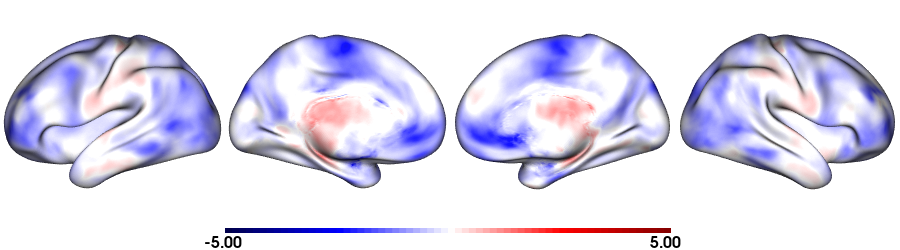

[visMean] [1] (MICs TLE_R thickness)


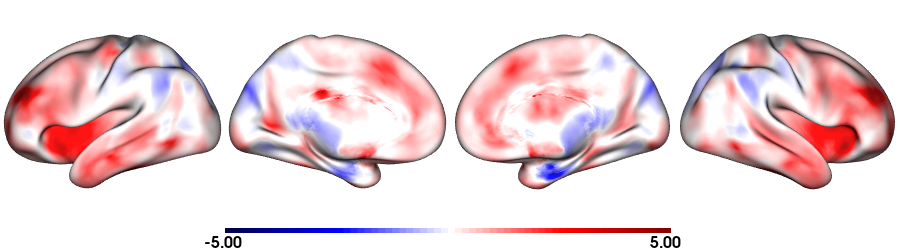

[visMean] [2] (PNI TLE_L thickness)


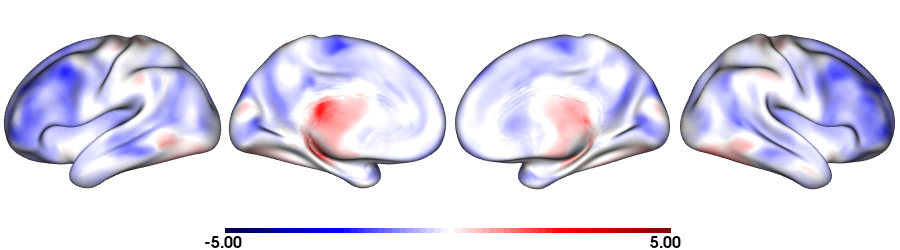

[visMean] [3] (PNI TLE_R thickness)


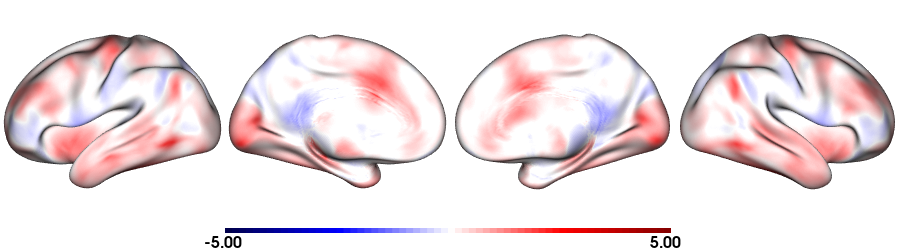

[visMean] [4] (MICs TLE_ic thickness)


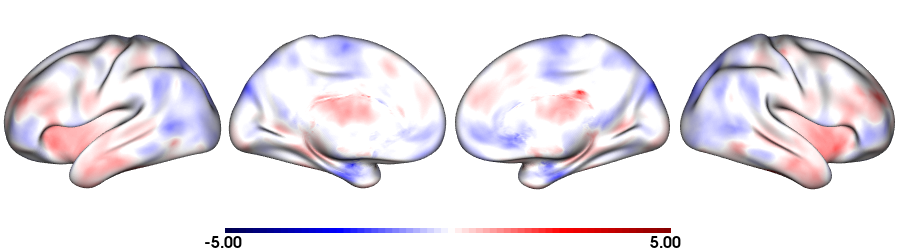

[visMean] [5] (PNI TLE_ic thickness)


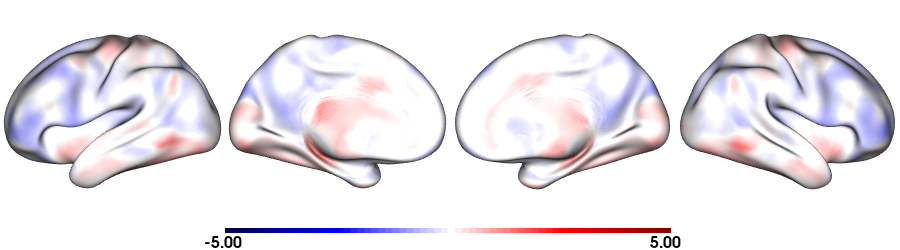

In [ ]:
# visualize mean z-scores for each group

importlib.reload(tsutil)

tsutil.visMean(
    stats_dictlist,
    title="Mean z-scores",
    ipsiTo="L"
)

# Group mean differences between studies

In [ ]:
path = ""

with open(path, "rb") as f:
    stats_dictlist = pickle.load(f)

tsutil.print_dict(stats_dictlist, df_print=False)

In [145]:
# compute difference betweenn vertex-wise means for all non-ctrl groups
# save outputs in comps list

importlib.reload(tsutil)

comps = []
new_items = []
skip_indices = []

for idx, stats_dict in enumerate(stats_dictlist):
    grp_idx = stats_dict['grp']
    if idx in skip_indices or grp_idx == 'ctrl':
        if idx not in skip_indices: skip_indices.append(idx)
        continue
    
    idx_other = tsutil.get_pair(stats_dictlist, idx, mtch=["grp", "label"])
    if idx_other is None:
        print(f"Warning: No paired group found for index {idx} ({grp_idx}). Skipping.")
        skip_indices.append(idx)
        continue
    skip_indices.append(idx_other)

    print(f"[z mean dif (7T-3T / 3T)] {grp_idx} ({stats_dict['label']}) (indices: {idx}, {idx_other})")

    assert df_z_idx.shape == df_z_other.shape, f"Shape mismatch: {df_z_idx.shape} vs {df_z_other.shape}"

    study = stats_dict['study']
    if study == "MICs":
        tT_df = stats_dict['df_z_mean']
        n_tT_grp = stats_dict['n_grp']
        n_tT_ctrl = stats_dict['n_ctrl']
        
        assert stats_dictlist[idx_other]['study'] == "PNI", f"Expected paired study to be `PNI `, got {stats_dictlist[idx_other]['study']}"
        sT_df = stats_dictlist[idx_other]['df_z_mean']
        n_sT_grp = stats_dictlist[idx_other]['n_grp']
        n_sT_ctrl = stats_dictlist[idx_other]['n_ctrl']

    elif study == "PNI":
        sT_df = stats_dict['df_z_mean']
        n_sT_grp = stats_dict['n_grp']
        n_sT_ctrl = stats_dict['n_ctrl']

        assert stats_dictlist[idx_other]['study'] == "MICs", f"Expected paired study to be `MICs`, got {stats_dictlist[idx_other]['study']}"
        tT_df = stats_dictlist[idx_other]['df_z_mean']
        n_tT_grp = stats_dictlist[idx_other]['n_grp']
        n_tT_ctrl = stats_dictlist[idx_other]['n_ctrl']
    else:
        print(f"Warning: Unknown study `{study}` for group {grp_idx}. Skipping.")
        continue

    # Dif in means: 7T - 3T / 3T
    df_z_dif = (sT_df - tT_df) / tT_df

    label = stats_dict['label']
    hipp = stats_dict['hippocampal']

    item = {
        'grp': grp_idx,
        'label': label,
        'hippocampal': hipp,
        'tT_index': idx,
        'sT_index': idx_other,
        'n_ctrl_3T': n_tT_ctrl,
        'n_ctrl_7T': n_sT_ctrl,
        'n_grp_3T': n_tT_grp,
        'n_grp_7T': n_sT_grp,
        'df_z_dif': df_z_dif
    }

    new_items.append(item)

comps.extend(new_items)

# save comps to a pickle file
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
save_name = f"{save_pth}/zdif_btwStudies_{date}.pkl"
with open(save_name, "wb") as f:
    pickle.dump(comps, f)
print(f"Saved comps to {save_name}")



[z mean dif (7T-3T / 3T)] TLE_L (thickness) (indices: 0, 2)
[z mean dif (7T-3T / 3T)] TLE_R (thickness) (indices: 1, 3)
[z mean dif (7T-3T / 3T)] TLE_ic (thickness) (indices: 4, 5)
Saved comps to /host/verges/tank/data/daniel/3T7T/z/outputs/results/zdif_btwStudies_11Jun2025-2057.pkl


In [147]:
tsutil.print_dict(comps, df_print=False)


 Dict list length (3 items)

[0]
	Keys: ['grp', 'label', 'hippocampal', 'tT_index', 'sT_index', 'n_ctrl_3T', 'n_ctrl_7T', 'n_grp_3T', 'n_grp_7T', 'df_z_dif']
	grp: TLE_L
	label: thickness
	hippocampal: False
	tT_index: 0
	sT_index: 2
	n_ctrl_3T: 11
	n_ctrl_7T: 12
	n_grp_3T: 5
	n_grp_7T: 5
	df_z_dif: <DataFrame shape=(1, 64984)>

[1]
	Keys: ['grp', 'label', 'hippocampal', 'tT_index', 'sT_index', 'n_ctrl_3T', 'n_ctrl_7T', 'n_grp_3T', 'n_grp_7T', 'df_z_dif']
	grp: TLE_R
	label: thickness
	hippocampal: False
	tT_index: 1
	sT_index: 3
	n_ctrl_3T: 11
	n_ctrl_7T: 12
	n_grp_3T: 4
	n_grp_7T: 5
	df_z_dif: <DataFrame shape=(1, 64984)>

[2]
	Keys: ['grp', 'label', 'hippocampal', 'tT_index', 'sT_index', 'n_ctrl_3T', 'n_ctrl_7T', 'n_grp_3T', 'n_grp_7T', 'df_z_dif']
	grp: TLE_ic
	label: thickness
	hippocampal: False
	tT_index: 4
	sT_index: 5
	n_ctrl_3T: 11
	n_ctrl_7T: 12
	n_grp_3T: 9
	n_grp_7T: 10
	df_z_dif: <DataFrame shape=(1, 64984)>


[visMean] [0] ( TLE_L thickness)


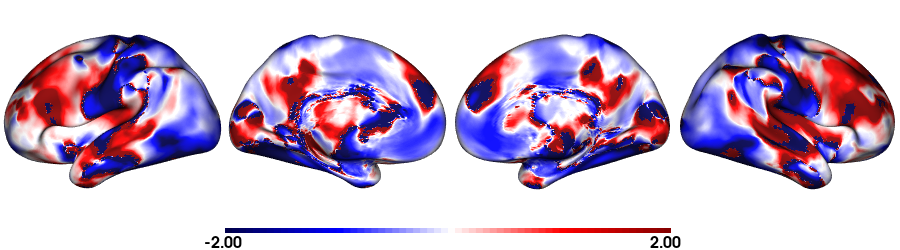

[visMean] [1] ( TLE_R thickness)


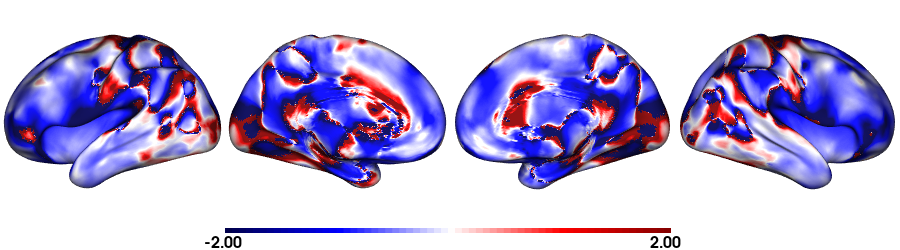

[visMean] [2] ( TLE_ic thickness)


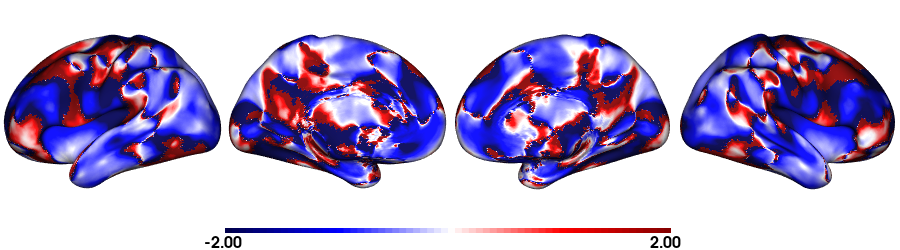

In [152]:
importlib.reload(tsutil)

tsutil.visMean(
    comps,
    df_name = "df_z_dif",
    title="Mean z difference (3T-7T / 3T)",
    ipsiTo="L"
)

# Create composite plots

In [154]:
pth_zmean = "/host/verges/tank/data/daniel/3T7T/z/outputs/stats/map_zStats_means_11Jun2025-2041.pkl"
pth_btwStudies = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/zdif_btwStudies_11Jun2025-2057.pkl"

zmean = pd.read_pickle(pth_zmean)
comps = pd.read_pickle(pth_btwStudies)

print(f"---------ZMEAN----------")
tsutil.print_dict(zmean, df_print=False)
print(f"\n\n---------COMPS----------")
tsutil.print_dict(comps, df_print=False)

---------ZMEAN----------

 Dict list length (6 items)

[0]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_grp', 'df_map_ctrl', 'df_z', 'df_z_mean']
	study: MICs
	grp: TLE_L
	label: thickness
	hippocampal: False
	n_ctrl: 11
	n_grp: 5
	df_map_grp: <DataFrame shape=(5, 64986)>
	df_map_ctrl: <DataFrame shape=(11, 64986)>
	df_z: <DataFrame shape=(5, 64984)>
	df_z_mean: <DataFrame shape=(1, 64984)>

[1]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_grp', 'df_map_ctrl', 'df_z', 'df_z_mean']
	study: MICs
	grp: TLE_R
	label: thickness
	hippocampal: False
	n_ctrl: 11
	n_grp: 4
	df_map_grp: <DataFrame shape=(4, 64986)>
	df_map_ctrl: <DataFrame shape=(11, 64986)>
	df_z: <DataFrame shape=(4, 64984)>
	df_z_mean: <DataFrame shape=(1, 64984)>

[2]
	Keys: ['study', 'grp', 'label', 'hippocampal', 'n_ctrl', 'n_grp', 'df_map_grp', 'df_map_ctrl', 'df_z', 'df_z_mean']
	study: PNI
	grp: TLE_L
	label: thickness
	hippocampal: False
	n_ctrl: 12
	n_grp: 5


In [ ]:
# identify paired items in zmean and comps
# send these three items to vis_win_comp

def vis_win_comp(tT_item, sT_item, comp_item, save_name=None, save_path = None, ipsiTo='L'):
    # in three rows, plot:
    # [0] 3T grp to ctrl : annotation 3T \n mean z ({n} 'grp' to {n} 'ctrl')
    # [1] 7T grp to ctrl : annotation 7T \n mean z ({n} 'grp' to {n} 'ctrl')
    # [2] 3T-7T grp to ctrl : z difference (7T - 3T / 3T)
    # annotate the figures with L/R (if grp is TLE_L or TLE_R) or ipsi/contra (if grp is TLE_IC)


In [ ]:
map_pths_clean = []
final_ses = []
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/pt"

# Step 1: Clean sessions for each item in map_pths using ses_clean
map_pths_clean = []
for item in map_pths:
    df = item['map_pths']
        # Clean sessions
    df_clean = ses_clean(df, ID_col="ID", method="newest", silent=True)
    if df_clean is not None and not df_clean.empty:
        new_item = item.copy()
        new_item['map_pths'] = df_clean
        map_pths_clean.append(new_item)

# save dictionary list to a pickle file
save_cleanMaps = "/host/verges/tank/data/daniel/3T7T/z/maps/paths"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f"{save_cleanMaps}/map_pths_{date}.pkl", "wb") as f:
    pickle.dump(map_pths_clean, f)
print(f"Saved map_pths to {save_cleanMaps}/map_pths_{date}.pkl")


# Step 2: Return sessions used per ID
save_finalSES = "/host/verges/tank/data/daniel/3T7T/z/outputs/pt"
finalSES = get_finalSES(map_pths_clean, demo=demographics, save_pth=save_finalSES, long=True, silent=True)

In [131]:
print_dict(map_pths_clean)


map_pths_clean (414 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k

# Add ipsi/contra groups

In [25]:
# Create ipsi-contra dict entries
grps = ["TLE_L", "TLE_R"]

ic_entries = []

print(len(map_pths_clean))

for study in studies:
    print(f"\n[flip_TLE] Processing study {study['name']} for ipsi-contra entries")
    # find all entries for the groups of interest
    index_list = [
        i for i, item in enumerate(map_pths_clean)
        if item['study'] == study['name'] and item['grp'] in grps
    ]
    print(index_list)
    print(f"\n{len(index_list)} entries for groups {grps}")

    paired = set()  # to keep track of paired indices
    loop_count = 0

    for i in index_list:
        if i in paired:
            continue
        else:
            paired.add(i)

        # Only pair if surface, label, and feature match
        item_i = map_pths_clean[i]
        grp_i = item_i['grp']
        df_i = item_i['map_pths']
        surface_i = item_i['surface']
        label_i = item_i['label']
        feature_i = item_i['feature']
        # add grp col to DF
        df_i['grp'] = grp_i

        if grp_i == 'TLE_L':
            grp_other = 'TLE_R'
        elif grp_i == 'TLE_R':
            grp_other = 'TLE_L'
        else:
            print(f"Skipping item {i} with group {grp_i} (not TLE_L or TLE_R)")
            continue

        # Find paired index with matching surface, label, feature, and opposite group
        other_i = None
        for j in index_list:
            if j == i or j in paired:
                continue
            item_j = map_pths_clean[j]
            if (
                item_j['grp'] == grp_other and
                item_j['surface'] == surface_i and
                item_j['label'] == label_i and
                item_j['feature'] == feature_i
            ):
                other_i = j
                break

        if other_i is not None:
            item_other = map_pths_clean[other_i]
            df_other = item_other['map_pths']
            if df_other is not None: df_other['grp'] = grp_other
            paired.add(other_i)
        else:
            item_other = None
            grp_other = None
            df_other = None

        print(f"\t{loop_count} {i} & {other_i} | {item_i['label']}, {item_i['feature']}, {item_i['surface']} | {grp_i} & {grp_other}")

        out = item_i.copy()  # copy to avoid modifying original

        # rename path cols
        # Find the correct map column names for L/R
        hemi_L = [col for col in df_i.columns if col.endswith('_L')]
        hemi_R = [col for col in df_i.columns if col.endswith('_R')]

        col_L = hemi_L[0]
        col_R = hemi_R[0]

        if grp_i == 'TLE_L':
            df_i = df_i.rename(columns={col_L: 'pth_ipsi', col_R: 'pth_contra'})
            if df_other is not None:
                df_other = df_other.rename(columns={col_R: 'pth_ipsi', col_L: 'pth_contra'})
        else:  # grp_i == 'TLE_R'
            df_i = df_i.rename(columns={col_R: 'pth_ipsi', col_L: 'pth_contra'})
            if df_other is not None:
                df_other = df_other.rename(columns={col_L: 'pth_ipsi', col_R: 'pth_contra'})

        # combine modified dfs
        if df_other is not None:
            dfs = pd.concat([df_i, df_other], ignore_index=True)
            out['grp_labels'] = [grp_i, grp_other]
        else:
            dfs = df_i
            out['grp_labels'] = [grp_i]

        out['map_pths'] = dfs  # add the combined dataframe to the output item
        out['grp'] = 'TLE_ic'  # ic for ipsi-contra

        # add to the list of outputs
        ic_entries.append(out)

        loop_count += 1

map_pths_clean_ic = map_pths_clean + ic_entries  # combine original entries with ipsi-contra entries

# Save the updated map_pths_clean to a pickle file
save_cleanMaps = "/host/verges/tank/data/daniel/3T7T/z/maps/paths"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f"{save_cleanMaps}/map_pths_clean_{date}.pkl", "wb") as f:
    pickle.dump(map_pths_clean_ic, f)
print(f"Saved map_pths_clean to {save_cleanMaps}/map_pths_clean_{date}.pkl")

NameError: name 'map_pths_clean' is not defined

In [132]:
# Find entries with TLE_L, pial, FA, MICs
selected = [item for item in map_pths_clean_ic if item['grp'] == 'TLE_R' and item['label'] == 'white' and item['feature'] == 'FA' and item['study'] == 'PNI']
print_dict(selected)


map_pths_clean (0 items):


In [133]:
# Print the structure of the selected items in map_pths_clean using index_list
print_dict(map_pths_clean_ic[270:290], df_print=False)


map_pths_clean (20 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(4, 6)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(4, 6)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: fsLR-5k
 label: white
 feature: T1map
 hippocampal: False
  map_pths: <DataFrame shape=(5, 6)>

Item 3:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: PNI
 grp: TLE_L
 grp_labels: ['TLE_L', 'mTLE_L']
 surface: 

In [123]:
# print structure of map_pths_clean
print_dict(map_pths_clean_ic)


map_pths_clean (468 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>

Item 2:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k

In [135]:
# print specific study-group combinations
print_grpDF(dict=map_pths_clean_ic, grp='ctrl', study='PNI', df="pth")

PNI-ctrl (['CTRL'])
         ID SES        Date  \
2    PNC003  02  13.06.2022   
6    PNC006  02  05.11.2022   
10   PNC011  02  11.11.2022   
14   PNC018  02  05.05.2023   
28   PNC019  a1  27.02.2025   
105  PNC024  a1  09.10.2024   
109  PNC025  a1  11.09.2024   
113  PNC026  a1  16.10.2024   
155  PNC037  a1  15.05.2025   
156  PNC038  a1  14.05.2025   

                                map_FA_fsLR-5k_white_L  \
2    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
6    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
10   /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
14   /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
28   /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
105  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
109  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
113  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
155  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
156  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   


In [ ]:
# Find path for specific participant
study = "PNI"
sub = "PNC018"
ses = "01"

grp_idx = "ctrl"

entry = next((item for item in map_pths if item['study'] == study and item['grp'] == grp_idx), None)

if entry is not None:
    df = entry['map_pths']
    row = df[(df[ID_col] == sub) & (df['SES'] == ses)]
    if not row.empty:
        print(row['pth_L'].values[0])
    else:
        print(f"No entry found for subject {sub} and session {ses}")
else:
    print(f"No entry found for study {study} and group {grp_idx}")

/data/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0/sub-PNC018/ses-01/maps/sub-PNC018_ses-01_hemi-L_surf-fsLR-5k_label-white_FA.func.gii


# Extract map values

In [7]:
import pickle

with open("/host/verges/tank/data/daniel/3T7T/z/maps/paths/map_pths_clean_03Jun2025-2138.pkl", "rb") as f:
    map_pths_clean_ic = pickle.load(f)


In [ ]:
print_dict([map_pths_clean_ic[25]], df_print=True)# print specific study-group combinations (prints first feature-label combination)


 dict: (1 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: 0p5mm
 label: midthickness
 feature: ADC
 hippocampal: True
  map_pths: <DataFrame shape=(19, 6)>
  map_pths:         ID SES        Date                  map_ADC_0p5mm_midthickness_hipp_L  \
176  PX119  01  30.08.2023  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
177  PX071  04  26.09.2023  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
181  PX137  01  06.03.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
182  PX148  01  06.05.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
184  PX153  01  28.05.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
185  PX158  01  11.06.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
189  PX168  01  20.08.2024  /host/verges/tank

In [27]:
# print specific study-group combinations (prints first feature-label combination)
print_grpDF(dict=map_pths_clean_ic, grp='allPX', study='MICs', hipp = True, df="maps")

MICs-allPX (['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R'])
        ID SES        Date  \
176  PX119  01  30.08.2023   
177  PX071  04  26.09.2023   
181  PX137  01  06.03.2024   
182  PX148  01  06.05.2024   
184  PX153  01  28.05.2024   
185  PX158  01  11.06.2024   
189  PX168  01  20.08.2024   
190  PX173  01  28.08.2024   
191  PX174  01  04.09.2024   
192  PX176  01  05.09.2024   
193  PX183  01  16.10.2024   
195  PX189  01  12.11.2024   
196  PX190  01  12.11.2024   
197  PX194  01  26.11.2024   
198  PX198  01  03.12.2024   
199  PX199  01  03.12.2024   
200  PX200  01  03.12.2024   
201  PX204  01  09.01.2025   
204  PX215  01  20.03.2025   

                                                                                             map_FA_0p5mm_outer_hipp_L  \
176  /host/verges/tank/data/daniel/3T7T/z/maps/sub-PX119_ses-01/sub-PX119_ses-01_map_FA_0p5mm_outer_L_smth-10.func.gii   
177  /host/verges/tank/data/daniel/3T

In [ ]:
# Each row is a vertex, each column is a subject-session
## note for ipsi/contra groups, the following map values are stored under keys : maps_ipsi, maps_contra
maps = []
print_dict(maps)

for item in map_pths_clean_ic:

    #print(f"{item['study']} - {item['grp']} - {item['feature']} - {item['label']} - {item['surface']}")

    df = item['map_pths']

    # Find the ID column (use existing variable if available)
    if 'ID_col' in globals():
        id_col = ID_col
    else:
        id_col = [col for col in df.columns if 'ID' in col.upper()][0]

    # identify pth columns
    pth_cols = [col for col in df.columns if col.startswith('pth_') or col.startswith('map_')]
    print(f"\t{pth_cols}")

    new_item = item.copy()  # Only copy once per item

    for pth in pth_cols:
        df_map = pd.DataFrame()
        for i, row in df.iterrows():
            sub = row[id_col]
            ses = row['SES']

            # extract map values
            val = row[pth]
            # Check for missing or invalid path
            if pd.isnull(val) or str(val).startswith("ERROR") or str(val).lower() == "nan":
                print(f"{item['study']} - {item['grp']} - {item['feature']} - {item['label']} - {item['surface']}")
                print(f"\t[main] WARNING: No map path for {sub} {ses} ({pth}): {val}")
                continue
            try:
                gii = nib.load(val)
                map_data = gii.darrays[0].data
            except Exception as e:
                print(f"\t[main] ERROR loading {val}: {e}")
                continue

            col_name = f"{sub}-{ses}"
            df_map[col_name] = map_data

        # add the dataframe to dict item if not empty
        key_name = pth.replace('pth_', '').replace('surf_', '')
        if not df_map.empty:
            new_item[f'{key_name}'] = df_map

    # add this item to the maps list
    maps.append(new_item)



 dict: (0 items):
MICs - allPX - FA - white - fsLR-5k
	['map_FA_fsLR-5k_white_L', 'map_FA_fsLR-5k_white_R']
MICs - allPX - ADC - white - fsLR-5k
	['map_ADC_fsLR-5k_white_L', 'map_ADC_fsLR-5k_white_R']
MICs - allPX - T1map - white - fsLR-5k
	['map_T1map_fsLR-5k_white_L', 'map_T1map_fsLR-5k_white_R']
MICs - allPX - FA - midthickness - fsLR-5k
	['map_FA_fsLR-5k_midthickness_L', 'map_FA_fsLR-5k_midthickness_R']
MICs - allPX - ADC - midthickness - fsLR-5k
	['map_ADC_fsLR-5k_midthickness_L', 'map_ADC_fsLR-5k_midthickness_R']
MICs - allPX - T1map - midthickness - fsLR-5k
	['map_T1map_fsLR-5k_midthickness_L', 'map_T1map_fsLR-5k_midthickness_R']
MICs - allPX - FA - pial - fsLR-5k
	['map_FA_fsLR-5k_pial_L', 'map_FA_fsLR-5k_pial_R']
MICs - allPX - ADC - pial - fsLR-5k
	['map_ADC_fsLR-5k_pial_L', 'map_ADC_fsLR-5k_pial_R']
MICs - allPX - T1map - pial - fsLR-5k
	['map_T1map_fsLR-5k_pial_L', 'map_T1map_fsLR-5k_pial_R']
MICs - allPX - FA - white - fsLR-32k
	['map_FA_fsLR-32k_white_L', 'map_FA_fsLR-32

In [32]:
# print the structure of the maps
print_dict(maps)



 dict: (468 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>
  map_map_FA_fsLR-5k_white_L: <DataFrame shape=(4842, 19)>
  map_map_FA_fsLR-5k_white_R: <DataFrame shape=(4842, 19)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>
  map_map_ADC_fsLR-5k_white_L: <Da

In [33]:
# print the unique values for the key 'grp' 
unique_grps = set(item['grp'] for item in maps)
print(f"Unique groups in maps: {unique_grps}")

Unique groups in maps: {'ctrl', 'TLE_ic', 'TLE_R', 'TLE', 'allPX', 'FCD', 'TLE_L', 'UKN', 'MFCL'}


In [34]:
# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/maps/map_dfs/"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/map_values_{date}.pkl', 'wb') as f:    pickle.dump(maps, f)

In [128]:
# print specific study-group combinations (prints first feature-label combination)
print_grpDF(dict=maps, grp='ctrl', study='PNI', df="maps")

# Statistics

In [11]:
def t_test(df1, df2, fdr=True, equal_var=False):
    """
    Perform a vertex wise t-test between two DataFrames.
    inputs:
        df1: pd.DataFrame with vertex data for group 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for group 2.
        fdr: whether to apply FDR correction to the p-values (default is True)
        equal_var: whether to assume equal variance between the two groups (default is False, i.e., Welch's t-test)

    outputs:
        df with shape n_vertices x 2 . Cols:
            't': t-statistic
            'p': p-value
            'p_fdr' < if fdr = True >: FDR-corrected p-value


    Note:
     - Assumes:
      - Values at each vertex are normally distributed
      - Participants are independent
      - Unequal variance
    """
    import pandas as pd
    from scipy import stats
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[t_test] DataFrames must have the same number of vertices (rows).")
    
    if df1.shape[1] < 2 or df2.shape[1] < 2:
        raise ValueError("[t_test] Each DataFrame must have at least two subjects for t-test. {}".format((df1.shape, df2.shape)))
    
    # Initialize output DataFrame
    out = pd.DataFrame(index=df1.index)
    out['t'] = np.nan
    out['p'] = np.nan
    out['p_fdr'] = np.nan

    # Perform t-test for each vertex
    for i in range(df1.shape[0]):
        t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)
        out.at[i, 't'] = t_stat
        out.at[i, 'p'] = p_val

    # FDR correction if requested
    if fdr:
        from statsmodels.stats.multitest import multipletests
        out['p_fdr'] = multipletests(out['p'], method='fdr_bh')[1]  # FDR correction

    return out


def d(df1, df2):
    """
    Calculate Cohen's d for each vertex between two DataFrames.

    inputs:
        df1: pd.DataFrame with vertex data for group 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for group 2.

    outputs:
        pd.DataFrame with shape n_vertices x 1. Cols:
            'd': Cohen's d value for each vertex
    """
    import pandas as pd
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[d] DataFrames must have the same number of vertices (rows).")
    
    if df1.shape[1] < 2 or df2.shape[1] < 2:
        raise ValueError("[d] Each DataFrame must have at least two subjects for d calculation. {}".format((df1.shape, df2.shape)))

    # Initialize output DataFrame
    out = pd.DataFrame(index=df1.index)
    out['d'] = np.nan
    
    # Calculate Cohen's d for each vertex
    for i in range(df1.shape[0]):
        mean1 = df1.iloc[i, :].mean()
        mean2 = df2.iloc[i, :].mean()
        std1 = df1.iloc[i, :].std(ddof=1)  # Sample standard deviation
        std2 = df2.iloc[i, :].std(ddof=1)
        n1 = df1.shape[1]
        n2 = df2.shape[1]

        pooled_std = np.sqrt(((n1 - 1) * std1**2 + (n2 - 1) * std2**2) / (n1 + n2 - 2))
        # Avoid division by zero: if pooled_std is zero, set d to np.nan
        if pooled_std == 0 or np.isnan(pooled_std):
            out.at[i, 'd'] = np.nan
        else:
            out.at[i, 'd'] = (mean1 - mean2) / pooled_std

    return out

def get_stats(maps, ipsiTo = "L", ctrl_lbl='ctrl', grps=['each'], fdr=True):
    """
    Perform statistical tests between groups in the maps list.
    
    inputs:
        maps: list of dictionary items with keys 'study', 'grp', 'label', 'feature', 'map_pths'
        ipsiTo: hemisphere to compare ipsilateral maps to (default is "L").
        ctrl_lbl: label for the control group (default is 'ctrl').
        grps: list of groups to run for. If "each", compare all groups to ctrl (except for ctrl grp to itself).
            Default is ["each"].

    outputs:
        stats: list of dictionary items with keys:
            'study': study name
            'grp': group name
            'label': surface label
            'feature': feature name
            't': t-statistic DataFrame
            'p': p-value DataFrame
            'p_fdr': FDR-corrected p-value DataFrame (if fdr=True)
            'd': Cohen's d DataFrame
    """

    import pandas as pd

    out = []

    if grps == ['each']:
        grps = list({item['grp'] for item in maps if item['grp'] != ctrl_lbl})

    for grp in grps:
        # find the index of these groups in the maps list
        grp_indices = [i for i, item in enumerate(maps) if item['grp'] == grp]
        
        for idx in grp_indices:
            comp = maps[idx]
            
            group = comp['grp']
            study = comp['study']
            surface = comp['surface']
            label = comp['label']
            feature = comp['feature']
            hippocampal = comp.get('hippocampal', False)
            print(f"\n[get_stats] [idx: {idx}] {study} {group} ({label}, {feature}, {surface}, {'hipp' if hippocampal else 'cort'})")
            
            # find the control group index
            idx_ctrl = ctrl_index(maps, idx)            
            ctrl = maps[idx_ctrl]
            
            if 'hippocampal' not in comp:
                comp['hippocampal'] = hippocampal
            
            comp_keys = [key for key in comp.keys() if key.startswith('map_') and not key.endswith('pths')]
            ctrl_keys = [key for key in ctrl.keys() if key.startswith('map_') and not key.endswith('pths')]
            print(f"\tMap keys: {comp_keys}")
            print(f"\tControl keys: {ctrl_keys}")

            for key in comp_keys: # compare L and/or R hemisphere maps
                
                if 'ipsi' in key:
                    ctrl_col = f"map_map_{feature}_{surface}_{label}_{ipsiTo}"
                    comp['ipsiTo'] = ipsiTo
                elif 'contra' in key and ipsiTo == "L":
                    ctrl_col = f"map_map_{feature}_{surface}_{label}_R"
                    comp['ipsiTo'] = ipsiTo
                elif 'contra' in key and ipsiTo == "R":
                    ctrl_col = f"map_map_{feature}_{surface}_{label}_L"
                    comp['ipsiTo'] = ipsiTo
                elif 'ipsi' in key or 'contra' in key:
                    assert key in ctrl_keys, f"Provided comparison key {key} not in control keys ({ctrl_keys}). Check that ipsiTo is set either to `L` or `R`."
                    continue  # skip if ipsi/contra is in key but not in control keys
                else:
                    ctrl_col = key

                # ensure that ctrl_col is in ctrl_keys
                if ctrl_col not in ctrl_keys:
                    print(f"\tWARNING. Control column {ctrl_col} not found in control keys. Skipping. {ctrl_keys}.")
                    break
                
                df_comp = comp[key]
                df_ctrl = ctrl[ctrl_col]
                print(f"\t{key}, ctrl: {ctrl_col} | comp: {df_comp.shape}, ctrl: {df_ctrl.shape}")

                n_ctrl = df_ctrl.shape[1]
                n_comp = df_comp.shape[1]

                # if n_ctrl and n_comp are not already in comp, add them. If they are, then assert that they are the same
                if 'n_ctrl' in comp and 'n_comp' in comp:
                    assert comp['n_ctrl'] == n_ctrl, f"Number of control participants changed from {comp['n_ctrl']} to {n_ctrl} for {key_stats}."
                    assert comp['n_comp'] == n_comp, f"Number of comparison participants changed from {comp['n_comp']} to {n_comp} for {key_stats}."
                else:
                    comp['n_ctrl'] = n_ctrl
                    comp['n_comp'] = n_comp

                if n_ctrl < 2 or n_comp < 2:
                    print(f"[main] Skipping case. too few participants for t-test ({n_comp} comp, {n_ctrl} ctrl).")
                    break
                
                out_t_p = t_test(df_comp, df_ctrl, fdr=True, equal_var=False)
                out_d = d(df_comp, df_ctrl)

                # combine results into a single DataFrame
                out_df = pd.DataFrame(index=df_comp.index)
                out_df['t'] = out_t_p['t']
                out_df['p'] = out_t_p['p']
                out_df['p_fdr'] = out_t_p['p_fdr']
                out_df['d'] = out_d['d']
            
                # new key:
                key_stats = key.replace('map_', 'stats_')

                # add out_df to the comp item
                comp[key_stats] = out_df
            
                #print(out_df.shape)

            # add to the list of outputs
            out.append(comp)

    return out


In [12]:
def get_idx_compl(ldict, idx, silent=True):
    """
    Given a list of dict items and an index, find comparison that is for the same group, label, feature, but different study. 
    Get the comparison dictionary item at a specific index from a list of comparison items.
    
    inputs:
        ldict: list of comparison dictionary items
        idx: index of the item to retrieve

    outputs:
        idx_compl: str, index of the comparison dictionary item that is complementary to input index

    """
    if idx < 0 or idx >= len(ldict):
        print(f"WARNING: Index {idx} out of bounds for list of length {len(ldict)}")
        return None

    study = ldict[idx]['study']

    if study == "PNI":
        other_study = "MICs"
    elif study == "MICs":
        other_study = "PNI"
    else:
        print(f"WARNING: [get_idx_compl] Study code {study} not recognized. Only 'PNI' and 'MICs' are currently supported.")
        return None

    # Find all other list items that differ only in study (ignore values for 'stats')
    idx_compl = [i for i, item in enumerate(ldict) if item['study'] == other_study and 
                        item['label'] == ldict[idx]['label'] and 
                        item['feature'] == ldict[idx]['feature'] and 
                        item['grp'] == ldict[idx]['grp'] and
                        item['surface'] == ldict[idx]['surface'] and
                        item.get('hippocampal', False) == ldict[idx].get('hippocampal', False)
                ]

    idx_compl = idx_compl[0] if idx_compl else None  # Get the first matching index, if any

    if idx_compl is None:
        print(f"WARNING: [get_idx_compl] No complementary item found for index {idx} in study {study}.")

    if not silent: print(f"[get_idx_compl] Complementary index {idx_compl}")
    return idx_compl

def stat_dif(df1, df2, stat_col='d'):
    """
    Calculate the difference between columns in two analogous DataFrames.
    df1 - df2

    inputs:
        df1: pd.DataFrame with statistics for comparisons between grp and ctrl for study 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for comparisons between grp and ctrl for study 2.
        stat_col: column name for to compare (default is 'd'). (must be present in both DataFrames)
            examples: 'd' for cohen's d, 't' for t-statistic

    outputs:
        pd.DataFrame with shape n_vertices x 1. Cols:
            'd_dif': Difference in Cohen's d value for each vertex
    """
    import pandas as pd
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[d_dif] DataFrames must have the same number of vertices (rows).")
    
    # Initialize output DataFrame
    out = pd.DataFrame()
    out[f'{stat_col}_dif'] = np.nan

    # take difference between d values
    for i in range(df1.shape[0]):
        d1 = df1.at[i, stat_col]
        d2 = df2.at[i, stat_col]
        
        if pd.isna(d1) or pd.isna(d2):
            out.at[i, f'{stat_col}_dif'] = np.nan
        else:
            out.at[i, f'{stat_col}_dif'] = d1 - d2  # Difference in Cohen's d

    return out

def stat_div(df1, df2, stat_col='d'):
    """
    Calculate the ratio between columns in two analogous DataFrames.
    df1 / df2

    inputs:
        df1: pd.DataFrame with statistics for comparisons between grp and ctrl for study 1. Vertices should be rows, subjects as columns.
        df2: pd.DataFrame with vertex data for comparisons between grp and ctrl for study 2.
        stat_col: column name for to compare (default is 'd'). (must be present in both DataFrames)
            examples: 'd' for cohen's d, 't' for t-statistic

    outputs:
        pd.DataFrame with shape n_vertices x 1. Cols:
            'd_div': Ratio in Cohen's d value for each vertex
    """
    import pandas as pd
    import numpy as np

    if df1.shape[0] != df2.shape[0]:
        raise ValueError("[d_div] DataFrames must have the same number of vertices (rows).")
    
    # Initialize output DataFrame
    out = pd.DataFrame()
    out[f'{stat_col}_div'] = np.nan

    # take ratio between d values
    for i in range(df1.shape[0]):
        d1 = df1.at[i, stat_col]
        d2 = df2.at[i, stat_col]
        
        if pd.isna(d1) or pd.isna(d2) or d2 == 0:
            out.at[i, f'{stat_col}_div'] = np.nan
        else:
            out.at[i, f'{stat_col}_div'] = d1 - d2 / d2  # Ratio in Cohen's d

    return out


In [7]:
# import maps from saved object

import pickle

path = "/host/verges/tank/data/daniel/3T7T/z/maps/map_dfs/map_values_06Jun2025-1808.pkl"

with open(path, "rb") as f:
    maps = pickle.load(f)


In [17]:
print_dict([maps[40]], df_print=True)


 dict: (1 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_ADC_fsLR-32k_midthickness_L', 'map_map_ADC_fsLR-32k_midthickness_R']
 study: MICs
 grp: TLE
 grp_labels: ['TLE_L', 'TLE_R', 'TLE_U', 'mTLE_R', 'mTLE_L']
 surface: fsLR-32k
 label: midthickness
 feature: ADC
 hippocampal: False
  map_pths: <DataFrame shape=(9, 6)>
  map_pths:         ID SES        Date                    map_ADC_fsLR-32k_midthickness_L  \
177  PX071  04  26.09.2023  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
182  PX148  01  06.05.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
189  PX168  01  20.08.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
190  PX173  01  28.08.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
191  PX174  01  04.09.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
195  PX189  01  12.11.2024  /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
196  PX190  01  12.11.2

In [13]:
# check map dfs. If L and R are not the same number, then keep only overlapping ID-ses. Save as maps_clean
# keys of interest: map_map_{feature}_{surface}_{label}_{hemi}

def clean_map_dfs(maps):
    """
    Clean map DataFrames if there are different number of cases in both map value dataframes. In this case, keep only overlapping subjects and sessions.
    
    inputs:
        maps: list of dictionary items with keys 'study', 'grp', 'label', 'feature', 'map_pths'
    
    outputs:
        maps_clean: list of dictionary items with cleaned map DataFrames
    """
    import pandas as pd

    maps_clean = []

    for item in maps:
        new_item = item.copy()  # Copy the item to avoid modifying the original
        map_keys = [key for key in item.keys() if key.startswith('map_') and not key.endswith('pths')]
        
        #print(f"[clean_map_dfs] Maps dataframe keys: {map_keys}")
        if len(map_keys) != 2:
            
            print(f"[clean_map_dfs] There are not exactly 2 map value keys. skipping.")
            continue

        df1 = new_item[map_keys[0]]
        df2 = new_item[map_keys[1]]
        if df1.shape[1] != df2.shape[1]:
            index = maps.index(item)
            print(f"[clean_map_dfs] [idx: {index}] Different number of cases in {map_keys[0]} ({df1.shape[1]}) and {map_keys[1]} ({df2.shape[1]}). Keeping only overlapping subjects and sessions.")
            
            # Get the first map DataFrame to use as a reference
            overlap_cols = df1.columns.intersection(df2.columns)

            if df1.shape[1] < df2.shape[1]:
                df2_new = df2[overlap_cols]
                new_item[map_keys[1]] = df2_new
            else:
                df1_new = df1[overlap_cols]
                new_item[map_keys[0]] = df1_new
        
        maps_clean.append(new_item)
        
    return maps_clean
    


In [43]:
maps_clean = clean_map_dfs(maps)

[clean_map_dfs] [idx: 18] Different number of cases in map_map_FA_0p5mm_outer_hipp_L (19) and map_map_FA_0p5mm_outer_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 19] Different number of cases in map_map_ADC_0p5mm_outer_hipp_L (19) and map_map_ADC_0p5mm_outer_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 20] Different number of cases in map_map_T1map_0p5mm_outer_hipp_L (19) and map_map_T1map_0p5mm_outer_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 21] Different number of cases in map_map_FA_0p5mm_inner_hipp_L (19) and map_map_FA_0p5mm_inner_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 22] Different number of cases in map_map_ADC_0p5mm_inner_hipp_L (19) and map_map_ADC_0p5mm_inner_hipp_R (18). Keeping only overlapping subjects and sessions.
[clean_map_dfs] [idx: 23] Different number of cases in map_map_T1map_0p5mm_inner_hipp_L (19) and map

In [44]:
print(len(maps))
print(len(maps_clean))

468
468


In [48]:
print_dict([maps[407]], df_print=True)
print_dict([maps_clean[407]], df_print=True)


 dict: (1 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_T1map_0p5mm_outer_hipp_L', 'map_map_T1map_0p5mm_outer_hipp_R']
 study: PNI
 grp: ctrl
 grp_labels: ['CTRL']
 surface: 0p5mm
 label: outer
 feature: T1map
 hippocampal: True
  map_pths: <DataFrame shape=(10, 6)>
  map_pths:            ID SES        Date  \
0    Pilot013  05  18.04.2024   
4      PNC003  04  24.10.2023   
8      PNC006  04  17.10.2023   
12     PNC011  04  03.08.2023   
17     PNC018  a1  10.02.2025   
21     PNC019  04  07.11.2023   
106    PNC024  a2  15.10.2024   
109    PNC025  a1  11.09.2024   
115    PNC026  a3  18.02.2025   
116    PNC031  a1  19.02.2025   

                          map_T1map_0p5mm_outer_hipp_L  \
0    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
4    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
8    /host/verges/tank/data/daniel/3T7T/z/maps/sub-...   
12   /host/verges/tank/data/daniel/3T7T/z/maps/

In [110]:
# FAILS for 32k surfaces (can't find overlapping keys in the control dict items)
# FAILS for TLE_ic hippocampal maps (can't find overlapping keys in the control dict items)

import datetime

# up to 15 mins for all groups
grps = ["allPX", "TLE_L", "TLE_R", "TLE_ic"]

comps = get_stats(maps_clean, grps = grps)

# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/comparisons_withinStudy_{date}.pkl', 'wb') as f:    pickle.dump(comps, f)
print(f"Saved comparisons to {save_pth}/comparisons_withinScanner_{date}.pkl")


[get_stats] [idx: 0] MICs allPX (white, FA, fsLR-5k, cort)
	Map keys: ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
	Control keys: ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
	map_map_FA_fsLR-5k_white_L, ctrl: map_map_FA_fsLR-5k_white_L | comp: (4842, 19), ctrl: (4842, 11)
	map_map_FA_fsLR-5k_white_R, ctrl: map_map_FA_fsLR-5k_white_R | comp: (4842, 19), ctrl: (4842, 11)

[get_stats] [idx: 1] MICs allPX (white, ADC, fsLR-5k, cort)
	Map keys: ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
	Control keys: ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
	map_map_ADC_fsLR-5k_white_L, ctrl: map_map_ADC_fsLR-5k_white_L | comp: (4842, 19), ctrl: (4842, 11)
	map_map_ADC_fsLR-5k_white_R, ctrl: map_map_ADC_fsLR-5k_white_R | comp: (4842, 19), ctrl: (4842, 11)

[get_stats] [idx: 2] MICs allPX (white, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	Control keys: ['map_map_T1map_fsLR-5k

/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_ADC_fsLR-5k_white_R, ctrl: map_map_ADC_fsLR-5k_white_R | comp: (4842, 2), ctrl: (4842, 11)

[get_stats] [idx: 83] MICs TLE_R (white, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	Control keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	map_map_T1map_fsLR-5k_white_L, ctrl: map_map_T1map_fsLR-5k_white_L | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_fsLR-5k_white_R, ctrl: map_map_T1map_fsLR-5k_white_R | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 84] MICs TLE_R (midthickness, FA, fsLR-5k, cort)
	Map keys: ['map_map_FA_fsLR-5k_midthickness_L', 'map_map_FA_fsLR-5k_midthickness_R']
	Control keys: ['map_map_FA_fsLR-5k_midthickness_L', 'map_map_FA_fsLR-5k_midthickness_R']
	map_map_FA_fsLR-5k_midthickness_L, ctrl: map_map_FA_fsLR-5k_midthickness_L | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_FA_fsLR-5k_midthickness_R, ctrl: map_map_FA_fsLR-5k_midthickness_R | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 85] MICs TLE_R (midthickness, ADC, fsLR-5k, cort)
	Map keys: ['map_map_ADC_fsLR-5k_midthickness_L', 'map_map_ADC_fsLR-5k_midthickness_R']
	Control keys: ['map_map_ADC_fsLR-5k_midthickness_L', 'map_map_ADC_fsLR-5k_midthickness_R']
	map_map_ADC_fsLR-5k_midthickness_L, ctrl: map_map_ADC_fsLR-5k_midthickness_L | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_ADC_fsLR-5k_midthickness_R, ctrl: map_map_ADC_fsLR-5k_midthickness_R | comp: (4842, 2), ctrl: (4842, 11)

[get_stats] [idx: 86] MICs TLE_R (midthickness, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_midthickness_L', 'map_map_T1map_fsLR-5k_midthickness_R']
	Control keys: ['map_map_T1map_fsLR-5k_midthickness_L', 'map_map_T1map_fsLR-5k_midthickness_R']
	map_map_T1map_fsLR-5k_midthickness_L, ctrl: map_map_T1map_fsLR-5k_midthickness_L | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_fsLR-5k_midthickness_R, ctrl: map_map_T1map_fsLR-5k_midthickness_R | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 87] MICs TLE_R (pial, FA, fsLR-5k, cort)
	Map keys: ['map_map_FA_fsLR-5k_pial_L', 'map_map_FA_fsLR-5k_pial_R']
	Control keys: ['map_map_FA_fsLR-5k_pial_L', 'map_map_FA_fsLR-5k_pial_R']
	map_map_FA_fsLR-5k_pial_L, ctrl: map_map_FA_fsLR-5k_pial_L | comp: (4842, 2), ctrl: (4842, 11)
	map_map_FA_fsLR-5k_pial_R, ctrl: map_map_FA_fsLR-5k_pial_R | comp: (4842, 2), ctrl: (4842, 11)

[get_stats] [idx: 88] MICs TLE_R (pial, ADC, fsLR-5k, cort)
	Map keys: ['map_map_ADC_fsLR-5k_pial_L', 'map_map_ADC_fsLR-5k_pial_R']
	Control keys: ['map_map_ADC_fsLR-5k_pial_L', 'map_map_ADC_fsLR-5k_pial_R']
	map_map_ADC_fsLR-5k_pial_L, ctrl: map_map_ADC_fsLR-5k_pial_L | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_ADC_fsLR-5k_pial_R, ctrl: map_map_ADC_fsLR-5k_pial_R | comp: (4842, 2), ctrl: (4842, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 89] MICs TLE_R (pial, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_pial_L', 'map_map_T1map_fsLR-5k_pial_R']
	Control keys: ['map_map_T1map_fsLR-5k_pial_L', 'map_map_T1map_fsLR-5k_pial_R']
	map_map_T1map_fsLR-5k_pial_L, ctrl: map_map_T1map_fsLR-5k_pial_L | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_fsLR-5k_pial_R, ctrl: map_map_T1map_fsLR-5k_pial_R | comp: (4842, 2), ctrl: (4842, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 90] MICs TLE_R (white, FA, fsLR-32k, cort)
	Map keys: ['map_map_FA_fsLR-32k_white_L', 'map_map_FA_fsLR-32k_white_R']
	Control keys: ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
	WARNING. Control column map_map_FA_fsLR-32k_white_L not found in control keys. Skipping. ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R'].

[get_stats] [idx: 91] MICs TLE_R (white, ADC, fsLR-32k, cort)
	Map keys: ['map_map_ADC_fsLR-32k_white_L', 'map_map_ADC_fsLR-32k_white_R']
	Control keys: ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
	WARNING. Control column map_map_ADC_fsLR-32k_white_L not found in control keys. Skipping. ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R'].

[get_stats] [idx: 92] MICs TLE_R (white, T1map, fsLR-32k, cort)
	Map keys: ['map_map_T1map_fsLR-32k_white_L', 'map_map_T1map_fsLR-32k_white_R']
	Control keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	WARNING. Control column map_map_T1ma

/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 101] MICs TLE_R (outer, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_outer_hipp_L', 'map_map_T1map_0p5mm_outer_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_outer_hipp_L', 'map_map_T1map_0p5mm_outer_hipp_R']
	map_map_T1map_0p5mm_outer_hipp_L, ctrl: map_map_T1map_0p5mm_outer_hipp_L | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_outer_hipp_R, ctrl: map_map_T1map_0p5mm_outer_hipp_R | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 102] MICs TLE_R (inner, FA, 0p5mm, hipp)
	Map keys: ['map_map_FA_0p5mm_inner_hipp_L', 'map_map_FA_0p5mm_inner_hipp_R']
	Control keys: ['map_map_FA_0p5mm_inner_hipp_L', 'map_map_FA_0p5mm_inner_hipp_R']
	map_map_FA_0p5mm_inner_hipp_L, ctrl: map_map_FA_0p5mm_inner_hipp_L | comp: (7262, 2), ctrl: (7262, 11)
	map_map_FA_0p5mm_inner_hipp_R, ctrl: map_map_FA_0p5mm_inner_hipp_R | comp: (7262, 2), ctrl: (7262, 11)

[get_stats] [idx: 103] MICs TLE_R (inner, ADC, 0p5mm, hipp)
	Map keys: ['map_map_ADC_0p5mm_inner_hipp_L', 'map_map_ADC_0p5mm_inner_hipp_R']
	Control keys: ['map_map_ADC_0p5mm_inner_hipp_L', 'map_map_ADC_0p5mm_inner_hipp_R']
	map_map_ADC_0p5mm_inner_hipp_L, ctrl: map_map_ADC_0p5mm_inner_hipp_L | comp: (7262, 2), ctrl: (7262, 11)
	map_map_ADC_0p5mm_inner_hipp_R, ctrl: map_map_ADC_0p5mm_inner_hipp_R | comp: (7262, 2), ctrl: (7262, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 104] MICs TLE_R (inner, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_inner_hipp_L', 'map_map_T1map_0p5mm_inner_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_inner_hipp_L', 'map_map_T1map_0p5mm_inner_hipp_R']
	map_map_T1map_0p5mm_inner_hipp_L, ctrl: map_map_T1map_0p5mm_inner_hipp_L | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_inner_hipp_R, ctrl: map_map_T1map_0p5mm_inner_hipp_R | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 105] MICs TLE_R (midthickness, FA, 0p5mm, hipp)
	Map keys: ['map_map_FA_0p5mm_midthickness_hipp_L', 'map_map_FA_0p5mm_midthickness_hipp_R']
	Control keys: ['map_map_FA_0p5mm_midthickness_hipp_L', 'map_map_FA_0p5mm_midthickness_hipp_R']
	map_map_FA_0p5mm_midthickness_hipp_L, ctrl: map_map_FA_0p5mm_midthickness_hipp_L | comp: (7262, 2), ctrl: (7262, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_FA_0p5mm_midthickness_hipp_R, ctrl: map_map_FA_0p5mm_midthickness_hipp_R | comp: (7262, 2), ctrl: (7262, 11)

[get_stats] [idx: 106] MICs TLE_R (midthickness, ADC, 0p5mm, hipp)
	Map keys: ['map_map_ADC_0p5mm_midthickness_hipp_L', 'map_map_ADC_0p5mm_midthickness_hipp_R']
	Control keys: ['map_map_ADC_0p5mm_midthickness_hipp_L', 'map_map_ADC_0p5mm_midthickness_hipp_R']
	map_map_ADC_0p5mm_midthickness_hipp_L, ctrl: map_map_ADC_0p5mm_midthickness_hipp_L | comp: (7262, 2), ctrl: (7262, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_ADC_0p5mm_midthickness_hipp_R, ctrl: map_map_ADC_0p5mm_midthickness_hipp_R | comp: (7262, 2), ctrl: (7262, 11)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 107] MICs TLE_R (midthickness, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_midthickness_hipp_L', 'map_map_T1map_0p5mm_midthickness_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_midthickness_hipp_L', 'map_map_T1map_0p5mm_midthickness_hipp_R']
	map_map_T1map_0p5mm_midthickness_hipp_L, ctrl: map_map_T1map_0p5mm_midthickness_hipp_L | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_midthickness_hipp_R, ctrl: map_map_T1map_0p5mm_midthickness_hipp_R | comp: (7262, 2), ctrl: (7262, 10)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 297] PNI TLE_R (white, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	Control keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	map_map_T1map_fsLR-5k_white_L, ctrl: map_map_T1map_fsLR-5k_white_L | comp: (4842, 3), ctrl: (4842, 12)
	map_map_T1map_fsLR-5k_white_R, ctrl: map_map_T1map_fsLR-5k_white_R | comp: (4842, 3), ctrl: (4842, 12)

[get_stats] [idx: 298] PNI TLE_R (midthickness, T1map, fsLR-5k, cort)
	Map keys: ['map_map_T1map_fsLR-5k_midthickness_L', 'map_map_T1map_fsLR-5k_midthickness_R']
	Control keys: ['map_map_T1map_fsLR-5k_midthickness_L', 'map_map_T1map_fsLR-5k_midthickness_R']
	map_map_T1map_fsLR-5k_midthickness_L, ctrl: map_map_T1map_fsLR-5k_midthickness_L | comp: (4842, 3), ctrl: (4842, 12)
	map_map_T1map_fsLR-5k_midthickness_R, ctrl: map_map_T1map_fsLR-5k_midthickness_R | comp: (4842, 3), ctrl: (4842, 12)

[get_stats] [idx: 299] PNI TLE_R (pial, T1map, fsLR-5k, cort)
	Map keys:

/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_outer_hipp_R, ctrl: map_map_T1map_0p5mm_outer_hipp_R | comp: (7262, 2), ctrl: (7262, 9)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 304] PNI TLE_R (inner, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_inner_hipp_L', 'map_map_T1map_0p5mm_inner_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_inner_hipp_L', 'map_map_T1map_0p5mm_inner_hipp_R']
	map_map_T1map_0p5mm_inner_hipp_L, ctrl: map_map_T1map_0p5mm_inner_hipp_L | comp: (7262, 2), ctrl: (7262, 9)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_inner_hipp_R, ctrl: map_map_T1map_0p5mm_inner_hipp_R | comp: (7262, 2), ctrl: (7262, 9)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)



[get_stats] [idx: 305] PNI TLE_R (midthickness, T1map, 0p5mm, hipp)
	Map keys: ['map_map_T1map_0p5mm_midthickness_hipp_L', 'map_map_T1map_0p5mm_midthickness_hipp_R']
	Control keys: ['map_map_T1map_0p5mm_midthickness_hipp_L', 'map_map_T1map_0p5mm_midthickness_hipp_R']
	map_map_T1map_0p5mm_midthickness_hipp_L, ctrl: map_map_T1map_0p5mm_midthickness_hipp_L | comp: (7262, 2), ctrl: (7262, 9)


/tmp/ipykernel_614964/1871557919.py:41: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(df1.iloc[i, :], df2.iloc[i, :], equal_var=equal_var)


	map_map_T1map_0p5mm_midthickness_hipp_R, ctrl: map_map_T1map_0p5mm_midthickness_hipp_R | comp: (7262, 2), ctrl: (7262, 9)

[get_stats] [idx: 414] MICs TLE_ic (white, FA, fsLR-5k, cort)
	Map keys: ['map_ipsi', 'map_contra']
	Control keys: ['map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R']
	map_ipsi, ctrl: map_map_FA_fsLR-5k_white_L | comp: (4842, 7), ctrl: (4842, 11)
	map_contra, ctrl: map_map_FA_fsLR-5k_white_R | comp: (4842, 7), ctrl: (4842, 11)

[get_stats] [idx: 415] MICs TLE_ic (white, ADC, fsLR-5k, cort)
	Map keys: ['map_ipsi', 'map_contra']
	Control keys: ['map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R']
	map_ipsi, ctrl: map_map_ADC_fsLR-5k_white_L | comp: (4842, 7), ctrl: (4842, 11)
	map_contra, ctrl: map_map_ADC_fsLR-5k_white_R | comp: (4842, 7), ctrl: (4842, 11)

[get_stats] [idx: 416] MICs TLE_ic (white, T1map, fsLR-5k, cort)
	Map keys: ['map_ipsi', 'map_contra']
	Control keys: ['map_map_T1map_fsLR-5k_white_L', 'map_map_T1map_fsLR-5k_white_R']
	map_ips

In [111]:
print_dict(comps)


 dict: (198 items):

Item 0:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R', 'ipsiTo', 'n_ctrl', 'n_comp', 'stats_stats_FA_fsLR-5k_white_L', 'stats_stats_FA_fsLR-5k_white_R']
 study: MICs
 grp: allPX
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 label: white
 feature: FA
 hippocampal: False
  map_pths: <DataFrame shape=(19, 6)>
  map_map_FA_fsLR-5k_white_L: <DataFrame shape=(4842, 19)>
  map_map_FA_fsLR-5k_white_R: <DataFrame shape=(4842, 19)>
 ipsiTo: L
 n_ctrl: 11
 n_comp: 19
  stats_stats_FA_fsLR-5k_white_L: <DataFrame shape=(4842, 4)>
  stats_stats_FA_fsLR-5k_white_R: <DataFrame shape=(4842, 4)>

Item 1:
  Keys: ['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_ADC_fsLR-5k_white_L', 'map_map_ADC_fsLR-5k_white_R', 'ipsiTo', 'n_ctrl', 'n_c

In [9]:
# read in comps from saved object
import pickle
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
with open(f"{save_pth}/comparisons_withinStudy_09Jun2025-1127.pkl", "rb") as f:
    comps = pickle.load(f)

In [14]:
# 10 mins or so

# get difference maps of difference maps (3T dif maps - 7T dif maps)

tTsT_comp = []
compl_list = set()

for idx in range(len(comps)):
    if idx in compl_list:
        continue

    idx_compl = get_idx_compl(comps, idx)
    
    if idx_compl is None:
        print(f"\t[main] WARNING: No complementary index found for index {idx} ({comps[idx]['grp']} {comps[idx]['feature']} {comps[idx]['surface']} {comps[idx]['label']}). Skipping.")
        continue

    compl_list.add(idx)
    compl_list.add(idx_compl)

    # Assign sT (7T/PNI) and tT (3T/MICs) for consistency
    if comps[idx]['study'] == "PNI":
        #print(f"[main] PNI comparison at index {idx} with complementary index {idx_compl}")
        if not comps[idx_compl]['study'] == "MICs":
            print(f"[main] ERROR. Complementary study should be MICs, but got {comps[idx_compl]['study']}.")
        sT = comps[idx]
        tT = comps[idx_compl]

    elif comps[idx]['study'] == "MICs":
        #print(f"[main] MICs comparison at index {idx} with complementary index {idx_compl}")
        if not comps[idx_compl]['study'] == "PNI":
            print(f"[main] ERROR. Complementary study should be PNI, but got {comps[idx_compl]['study']}.")
        sT = comps[idx_compl]
        tT = comps[idx]

    group = sT['grp']
    feature = sT['feature']
    label = sT['label']
    surface = sT.get('surface', 'unknown')  # default to 'unknown' if not present
    grp_lbls = sT['grp_labels']
    print(f"[main] MICs: {idx}, PNI: {idx_compl}. {group}, {feature}, {label}, {surface}.")
    if not (group == tT['grp'] and feature == tT['feature'] and label == tT['label'] and grp_lbls == tT['grp_labels']):
        print(f"\tSkipping. Mismatch in ≥1 of: group ({group} vs {tT['grp']}), feature ({feature} vs {tT['feature']}), label ({label} vs {tT['label']}), group labels ({grp_lbls} vs {tT['grp_labels']})")
        continue

    # identify overlapping stats keys
    stats_keys = [k for k in sT.keys() if k.startswith('stats')]
    stats_keys = [k for k in stats_keys if k in tT.keys() and sT[k].shape[0] == tT[k].shape[0]]
    if not stats_keys:
        print(f"\tWARNING: No overlapping stats keys. tT n: {tT.get('n_comp')}, sT n: {sT.get('n_comp')}")
        continue

    print(f"\tOverlapping keys: {stats_keys}")
    
    # create dict element for this comparison
    comparison = {
        'grp': group,
        'feature': feature,
        'label': label,
        'grp_labels': grp_lbls,
        'surface': surface,
        'n_grp_sT': sT['n_comp'],
        'n_grp_tT': tT['n_comp'],
        'n_ctrl_sT': sT['n_ctrl'],
        'n_ctrl_tT': tT['n_ctrl'],
    }

    for key in stats_keys:
        # take df from analogous keys
        sT_df = sT[key]
        tT_df = tT[key]

        # merge sT_df and tT_df into df_dif. Add suffixes related to tT and sT
        df_dif = pd.concat([sT_df.add_suffix('_sT'), tT_df.add_suffix('_tT')], axis=1)

        assert sT_df.shape[0] == tT_df.shape[0], f"[main] ERROR. Different number of vertices in stats DataFrames: {sT_df.shape[0]} vs {tT_df.shape[0]} for key {key}."

        # compute differences - sT - tT
        df_dif['d_dif'] = stat_dif(sT_df, tT_df, stat_col='d')
        df_dif['d_div'] = stat_div(sT_df, tT_df, stat_col='d')
        df_dif['t_dif'] = stat_dif(sT_df, tT_df, stat_col='t')
        df_dif['t_div'] = stat_div(sT_df, tT_df, stat_col='t')

        # add df_dif to the comparison dict
        comparison[key + '_dif'] = df_dif

    # add comparison dict to the stats list
    tTsT_comp.append(comparison)

# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/comp_btwScanners_{date}.pkl', 'wb') as f:
    pickle.dump(tTsT_comp, f)


[main] MICs: 0, PNI: 27. allPX, FA, white, fsLR-5k.
	Overlapping keys: ['stats_stats_FA_fsLR-5k_white_L', 'stats_stats_FA_fsLR-5k_white_R']
[main] MICs: 1, PNI: 28. allPX, ADC, white, fsLR-5k.
	Overlapping keys: ['stats_stats_ADC_fsLR-5k_white_L', 'stats_stats_ADC_fsLR-5k_white_R']
[main] MICs: 2, PNI: 29. allPX, T1map, white, fsLR-5k.
	Overlapping keys: ['stats_stats_T1stats_fsLR-5k_white_L', 'stats_stats_T1stats_fsLR-5k_white_R']
[main] MICs: 3, PNI: 30. allPX, FA, midthickness, fsLR-5k.
	Overlapping keys: ['stats_stats_FA_fsLR-5k_midthickness_L', 'stats_stats_FA_fsLR-5k_midthickness_R']
[main] MICs: 4, PNI: 31. allPX, ADC, midthickness, fsLR-5k.
	Overlapping keys: ['stats_stats_ADC_fsLR-5k_midthickness_L', 'stats_stats_ADC_fsLR-5k_midthickness_R']
[main] MICs: 5, PNI: 32. allPX, T1map, midthickness, fsLR-5k.
	Overlapping keys: ['stats_stats_T1stats_fsLR-5k_midthickness_L', 'stats_stats_T1stats_fsLR-5k_midthickness_R']
[main] MICs: 6, PNI: 33. allPX, FA, pial, fsLR-5k.
	Overlapping k

In [114]:
print_dict(tTsT_comp)


 dict: (45 items):

Item 0:
  Keys: ['grp', 'feature', 'label', 'grp_labels', 'surface', 'n_grp_sT', 'n_grp_tT', 'n_ctrl_sT', 'n_ctrl_tT', 'stats_stats_FA_fsLR-5k_white_L_dif', 'stats_stats_FA_fsLR-5k_white_R_dif']
 grp: allPX
 feature: FA
 label: white
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 n_grp_sT: 11
 n_grp_tT: 19
 n_ctrl_sT: 10
 n_ctrl_tT: 11
  stats_stats_FA_fsLR-5k_white_L_dif: <DataFrame shape=(4842, 12)>
  stats_stats_FA_fsLR-5k_white_R_dif: <DataFrame shape=(4842, 12)>

Item 1:
  Keys: ['grp', 'feature', 'label', 'grp_labels', 'surface', 'n_grp_sT', 'n_grp_tT', 'n_ctrl_sT', 'n_ctrl_tT', 'stats_stats_ADC_fsLR-5k_white_L_dif', 'stats_stats_ADC_fsLR-5k_white_R_dif']
 grp: allPX
 feature: ADC
 label: white
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 n_grp_sT: 11
 n_grp_tT: 19
 n_ctrl_sT: 10


In [115]:
# save dictionary item
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results"
date = datetime.datetime.now().strftime("%d%b%Y-%H%M")
with open(f'{save_pth}/comp_btwScanners_{date}.pkl', 'wb') as f:    pickle.dump(comps, f)
print(f"Saved comparisons to {save_pth}/comp_btwScanners_{date}.pkl")

Saved comparisons to /host/verges/tank/data/daniel/3T7T/z/outputs/results/comp_btwScanners_09Jun2025-1139.pkl


In [116]:
# print the structure of the tTsT_comp
print_dict(tTsT_comp)


 dict: (45 items):

Item 0:
  Keys: ['grp', 'feature', 'label', 'grp_labels', 'surface', 'n_grp_sT', 'n_grp_tT', 'n_ctrl_sT', 'n_ctrl_tT', 'stats_stats_FA_fsLR-5k_white_L_dif', 'stats_stats_FA_fsLR-5k_white_R_dif']
 grp: allPX
 feature: FA
 label: white
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 n_grp_sT: 11
 n_grp_tT: 19
 n_ctrl_sT: 10
 n_ctrl_tT: 11
  stats_stats_FA_fsLR-5k_white_L_dif: <DataFrame shape=(4842, 12)>
  stats_stats_FA_fsLR-5k_white_R_dif: <DataFrame shape=(4842, 12)>

Item 1:
  Keys: ['grp', 'feature', 'label', 'grp_labels', 'surface', 'n_grp_sT', 'n_grp_tT', 'n_ctrl_sT', 'n_ctrl_tT', 'stats_stats_ADC_fsLR-5k_white_L_dif', 'stats_stats_ADC_fsLR-5k_white_R_dif']
 grp: allPX
 feature: ADC
 label: white
 grp_labels: ['TLE_U', 'MFCL', 'FLE_R', 'MFCL_bTLE', 'UKN_L', 'mTLE_R', 'mTLE_L', 'FLE_L', 'UKN_U', 'TLE_L', 'TLE_R']
 surface: fsLR-5k
 n_grp_sT: 11
 n_grp_tT: 19
 n_ctrl_sT: 10


# Visualizations
- Show 7T comparison (grp vs ctrl), 3T (grp vs ctrl), difference between 3T and 7T
- Parcellation analyses (bar graph)

In [1]:
import pickle
# Load tTsT_comp from saved object
path = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/comp_btwScanners_09Jun2025-1139.pkl"
with open(path, "rb") as f:
    tTsT_comp = pickle.load(f)

In [3]:
print_dict(tTsT_comp)

NameError: name 'print_dict' is not defined

In [ ]:
import datetime

save = False
save_pth = "/host/verges/tank/data/daniel/3T7T/z/outputs/results/fig_stats/figs"
metric = 'd_div' 

for idx, i in enumerate(tTsT_comp):
    grp_idx = i['grp']
    feature = i['feature']
    label = i['label']
    surface = i.get('surface', 'unknown')  # default to 'unknown' if not present
    # Skip if 'hippocampal' key is missing or False
    if not i.get('hippocampal', True):
        pass
    elif (i.get('hippocampal', False) is True) or (surface == '0p5mm'):
        surface = '0p5mm'
        continue  # skip hippocampal maps for now, need to plot on a different surface
    if surface == 'unknown':
       surface = 'fsLR-5k'
    
    print(f"\n[main] {idx} {grp_idx}, {feature}, {label}, {surface}")
    print(f"\t{metric} {i.keys()}")
    
    if 'stats_contra_dif' in i.keys() and 'stats_ipsi_dif' in i.keys():
        ic = True
        ipsiTo = i['ipsiTo']
        print(f"[{idx}] ipsi/contra keys found. Using ipsiTo={ipsiTo}.")
        
        if ipsiTo == "L":
            lh = i['stats_ipsi_dif'][metric]
            rh = i['stats_contra_dif'][metric]
            print(lh.shape, rh.shape)
            
        elif ipsiTo == "R":
            lh = i['stats_contra_dif'][metric]
            rh = i['stats_ipsi_dif'][metric]
            print(lh.shape, rh.shape)

    elif 'stats_L_dif' in i.keys() and 'stats_R_dif' in i.keys():
        print(f"[{idx}] L/R keys found")
        lh = i['stats_L_dif'][metric]
        rh = i['stats_R_dif'][metric]
        print(lh.shape, rh.shape)
    else:
        if feature == 'T1map':
            lh = i[f'stats_stats_T1stats_{surface}_{label}_L_dif'][metric]
            rh = i[f'stats_stats_T1stats_{surface}_{label}_L_dif'][metric]
        else:
            if surface == '0p5mm':
                continue
            lh = i[f'stats_stats_{feature}_{surface}_{label}_L_dif'][metric]
            rh = i[f'stats_stats_{feature}_{surface}_{label}_L_dif'][metric]
    
    if metric == 'd_dif':
        metric_lbl = "Δd"
    elif metric == 't_dif':
        metric_lbl = "Δt"
    else:
        metric_lbl = metric

    fig_title = f"{metric_lbl} (7T-3T): {i['grp']}, {i['feature']}, {i['label']} surface (grp:ctrl 7T: {i['n_grp_sT']}:{i['n_ctrl_sT']}, 3T: {i['n_grp_tT']}:{i['n_ctrl_tT']})"

    name = f"{metric}_{i['grp']}_{i['feature']}_{i['label']}"

    from IPython.display import display, Markdown
    display(Markdown(f"### {fig_title}"))
    #showBrains(lh, rh, surface='fsLR-5k', min=-2.5, max=2.5, inflated=False, title = fig_title, save_name = name, save_pth=save_pth)
    fig = showBrains(lh, rh, surface='fsLR-5k', ipsiTo = ipsiTo, min=-2.5, max=2.5, inflated=True, title = fig_title)
    # save figure
    if save == True:
        fig = showBrains(lh, rh, surface='fsLR-5k', min=-2, max=2, inflated=False, title = fig_title, save_name = name, save_pth=save_pth)
    else:
        fig = showBrains(lh, rh, surface='fsLR-5k', min=-2, max=2, inflated=False, title = fig_title)
    
    display(fig)


[main] 0 allPX, FA, white, fsLR-5k
	d_div dict_keys(['study', 'grp', 'grp_labels', 'surface', 'label', 'feature', 'hippocampal', 'map_pths', 'map_map_FA_fsLR-5k_white_L', 'map_map_FA_fsLR-5k_white_R', 'ipsiTo', 'n_ctrl', 'n_comp', 'stats_stats_FA_fsLR-5k_white_L', 'stats_stats_FA_fsLR-5k_white_R'])


KeyError: 'stats_stats_FA_fsLR-5k_white_L_dif'

In [ ]:
# TO DO: 
## Visualize 3T and 7T comparison maps
## Bar graphs for parcellations

In [ ]:
# check correspondence between veretices L and R <optional: thorough>